# Sea Level Rise Analysis: Data Loading and Preprocessing

This notebook loads and preprocesses global mean sea level (GMSL) and global mean surface temperature (GMST) datasets for estimating the transient sea level sensitivity parameter α.

**Analysis Framework is intentionally simple to provide a baseline for further analysis:**
$$\alpha = \frac{d(\text{GMSL rate})}{dT} \approx \frac{\text{GMSL acceleration}}{\text{Warming rate}}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly

from pathlib import Path
from slr_data_readers import (
    read_frederikse2020, read_dangendorf2024, read_horwath2022, read_nasa_gmsl, read_ipcc_ar6_observed_gmsl,
    read_berkeley_earth, read_hadcrut5, read_nasa_gistemp, read_noaa_globaltemp, read_imbie_west_antarctica,
    read_dangendorf2024_fields
)
from slr_analysis import harmonize_baseline, compute_thermodynamic_signal

BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
DATA_RAW_DIR = DATA_DIR / 'raw'
DATA_GMSLR_DIR = DATA_RAW_DIR / 'gmslr'
DATA_GMST_DIR = DATA_RAW_DIR / 'gmst'
DATA_ICESHEETS_DIR = DATA_RAW_DIR / 'ice_sheets'

SEALEVEL_UNITS = 'm'
TEMPERATURE_UNITS = 'c'
TIME_UNITS = 'y'

plt.rcParams['figure.figsize'] = (12, 6)



---
## 1. Global Mean Sea Level Datasets
---

### 1.1 Frederikse et al. (2020) — Sea Level Budget Reconstruction

**Description:** Budget-closed reconstruction of GMSL from 1900–2018, decomposed into contributions from thermosteric expansion, glaciers, ice sheets, and terrestrial water storage.

**Temporal Coverage:** 1900–2018 (annual)  
**Key Variables:** GMSL, steric, glaciers, greenland, antarctica, tws

**Reference:**
> Frederikse, T., et al. (2020). The causes of sea-level rise since 1900. *Nature*, 584(7821), 393–397. https://doi.org/10.1038/s41586-020-2591-3

```bibtex
@article{Frederikse2020,
  author  = {Frederikse, Thomas and Landerer, Felix and Caron, Lambert and Adhikari, Surendra and Parkes, David and Humphrey, Vincent W. and Dangendorf, S{\"o}nke and Hogarth, Peter and Zanna, Laure and Cheng, Lijing and Wu, Yun-Hao},
  title   = {The causes of sea-level rise since 1900},
  journal = {Nature},
  year    = {2020},
  volume  = {584},
  pages   = {393--397},
  doi     = {10.1038/s41586-020-2591-3}
}
```

In [2]:
df_frederikse = read_frederikse2020(DATA_GMSLR_DIR / 'frederikse2020_global_timeseries.xlsx')
print(f"Period: {df_frederikse.index.min().year} to {df_frederikse.index.max().year}")
print(f"Key columns: {[c for c in df_frederikse.columns if not '_lower' in c and not '_upper' in c][:10]}")
#df_frederikse[['gmsl', 'steric', 'glaciers', 'greenland', 'antarctica', 'tws']].head()

Period: 1900 to 2018
Key columns: ['year', 'gmsl', 'sum_contributors', 'steric', 'glaciers', 'greenland', 'antarctica', 'tws', 'reservoir', 'groundwater']


### 1.2 Dangendorf et al. (2019, 2024) — Kalman Smoother Reconstruction

**Description:** Hybrid tide gauge reconstruction using Kalman smoother methodology.

**Temporal Coverage:** 1900–present (monthly)  
**Key Variables:** GMSL

**Reference:**
> Dangendorf, S., et al. (2019). Persistent acceleration in global sea-level rise since the 1960s. *Nature Climate Change*, 9(9), 705–710. https://doi.org/10.1038/s41558-019-0531-8

```bibtex
@article{Dangendorf2019,
  author  = {Dangendorf, S{\"o}nke and Hay, Carling and Calafat, Francisco M. and Marcos, Marta and Piecuch, Christopher G. and Berk, Kevin and Jensen, J{\"u}rgen},
  title   = {Persistent acceleration in global sea-level rise since the 1960s},
  journal = {Nature Climate Change},
  year    = {2019},
  volume  = {9},
  pages   = {705--710},
  doi     = {10.1038/s41558-019-0531-8}
}
```

In [3]:
df_dangendorf = read_dangendorf2024_fields(DATA_GMSLR_DIR)
print(f"Period: {df_dangendorf.index.min()} to {df_dangendorf.index.max()}")
print(f"Columns: {list(df_dangendorf.columns)}")
#df_dangendorf.head()

Period: 1900-01-01 00:00:00 to 2021-01-01 00:00:00
Columns: ['gmsl', 'gmsl_relative', 'sterodynamic', 'barystatic', 'gia', 'gmsl_sigma', 'sterodynamic_sigma', 'barystatic_sigma', 'gia_sigma', 'decimal_year']


### 1.3 Horwath et al. (2022) — ESA CCI Sea Level Budget Closure

**Description:** GRACE/GRACE-FO derived mass contributions with budget closure analysis.

**Temporal Coverage:** 1993–2016 (monthly)  
**Reference Period:** 2006-01 to 2015-12  
**Key Variables:** GMSL, steric, ocean mass, glaciers, ice sheets, TWS

**Reference:**
> Horwath, M., et al. (2022). Global sea-level budget and ocean-mass budget. *Earth System Science Data*, 14(2), 411–447. https://doi.org/10.5194/essd-14-411-2022

```bibtex
@article{Horwath2022,
  author  = {Horwath, Martin and Gutknecht, Benjamin D. and Cazenave, Anny and others},
  title   = {Global sea-level budget and ocean-mass budget, with a focus on advanced data products and uncertainty characterisation},
  journal = {Earth System Science Data},
  year    = {2022},
  volume  = {14},
  pages   = {411--447},
  doi     = {10.5194/essd-14-411-2022}
}
```

In [4]:
df_horwath = read_horwath2022(DATA_GMSLR_DIR / 'horwath2021_ESACCI_SLBC_v2.2.csv')
print(f"Period: {df_horwath.index.min().strftime('%Y-%m')} to {df_horwath.index.max().strftime('%Y-%m')}")
print(f"Records: {len(df_horwath)}")
#df_horwath[['gmsl', 'steric_dieng', 'glaciers', 'greenland', 'antarctica_altimetry', 'tws']].head()

Period: 1993-01 to 2016-12
Records: 288


### 1.4 NASA GSFC — Satellite Altimetry GMSL

**Description:** Merged TOPEX/Poseidon, Jason-1/2/3, and Sentinel-6 altimetry.

**Temporal Coverage:** 1993–present (~10-day)  
**Data Version:** TPJAOS 5.2

**References:**
> Beckley, B. D., et al. (2017). On the "Cal-Mode" Correction to TOPEX Satellite Altimetry. *JGR: Oceans*, 122(11), 8371–8384. https://doi.org/10.1002/2017JC013090

```bibtex
@article{Beckley2017,
  author  = {Beckley, Brian D. and Callahan, Philip S. and Hancock, David W. and Mitchum, Gary T. and Ray, Richard D.},
  title   = {On the ``Cal-Mode'' Correction to {TOPEX} Satellite Altimetry},
  journal = {Journal of Geophysical Research: Oceans},
  year    = {2017},
  volume  = {122},
  pages   = {8371--8384},
  doi     = {10.1002/2017JC013090}
}

@misc{NASA_GMSL,
  author = {{NASA GSFC}},
  title  = {Global Mean Sea Level from Integrated Multi-Mission Ocean Altimeters, Version 5.2},
  year   = {2024},
  doi    = {10.5067/GMSLM-TJ152}
}
```

In [5]:
df_nasa_gmsl = read_nasa_gmsl(DATA_GMSLR_DIR / 'nasa_GMSL_TPJAOS_5.2.txt')
print(f"Period: {df_nasa_gmsl.index.min().strftime('%Y-%m-%d')} to {df_nasa_gmsl.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_nasa_gmsl)}")
#df_nasa_gmsl.head()

Period: 1993-01-05 to 2025-05-06
Records: 1191


### 1.5 IPCC AR6 — Observed Global Mean Sea Level

**Description:** Observed GMSL from IPCC Sixth Assessment Report (Working Group I, Chapter 9).

**Temporal Coverage:** 1950–2020 (annual)  
**Uncertainty:** 66% confidence interval (17th–83rd percentiles)

**Reference:**
> Fox-Kemper, B., et al. (2021). Ocean, Cryosphere and Sea Level Change. In *Climate Change 2021: The Physical Science Basis* (pp. 1211–1362). Cambridge University Press. https://doi.org/10.1017/9781009157896.011
```bibtex
@incollection{FoxKemper2021,
  author    = {Fox-Kemper, Baylor and Hewitt, Helene T. and Xiao, Cunde and others},
  title     = {Ocean, Cryosphere and Sea Level Change},
  booktitle = {Climate Change 2021: The Physical Science Basis},
  publisher = {Cambridge University Press},
  year      = {2021},
  pages     = {1211--1362},
  doi       = {10.1017/9781009157896.011}
}
```

In [6]:
df_ipcc_observed_gmsl = read_ipcc_ar6_observed_gmsl(DATA_GMSLR_DIR / 'ipccar6_global_sea_level_observed.csv')
print(f"Period: {df_ipcc_observed_gmsl.index.min().strftime('%Y-%m-%d')} to {df_ipcc_observed_gmsl.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_ipcc_observed_gmsl)}")
#df_ipcc_observed_gmsl.head()

Period: 1950-07-01 to 2020-07-01
Records: 71


### 1.6 IMBIE -- West Antarctica GMSLR contribution

**Description** Ice Mass Balance Inter-comparison Exercise (IMBIE) reconciled estimates of West Antarctic Ice Sheet mass balance from satellite observations.

**Temporal coverage:** 1992-01 to 2020-12 (monthly)
**Uncertainty:** standard deviation

**Reference:**
>Otosaka et al. (2023) Mass balance of the Greenland and Antarctic ice sheets
    from 1992 to 2020. Earth Syst. Sci. Data, 15, 1597–1616.
    https://doi.org/10.5194/essd-15-1597-2023

>https://imbie.org/data-downloads/
```bibtex
@article{otosaka_imbie_2023,
        title = {Mass balance of the {Greenland} and {Antarctic} ice sheets from 1992 to 2020},
        volume = {15},
        doi = {10.5194/essd-15-1597-2023},
        number = {4},
        journal = {Earth System Science Data},
        year = {2023},
        pages = {1597--1616},
}
```

In [7]:
df_imbie_wais = read_imbie_west_antarctica(DATA_ICESHEETS_DIR / 'antarctica/imbie_west_antarctica_2021_mm.csv')
print(f"Period: {df_imbie_wais.index.min().strftime('%Y-%m-%d')} to {df_imbie_wais.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_imbie_wais)}")
#df_imbie_wais.head()

Period: 1992-01-01 to 2020-12-01
Records: 348


---
## 2. Global Mean Surface Temperature Datasets
---

### 2.1 Berkeley Earth Land/Ocean Temperature

**Temporal Coverage:** 1850–present (monthly)  
**Baseline:** 1951–1980

**Reference:**
> Rohde, R. A., & Hausfather, Z. (2020). The Berkeley Earth Land/Ocean Temperature Record. *ESSD*, 12(4), 3469–3479. https://doi.org/10.5194/essd-12-3469-2020

```bibtex
@article{Rohde2020,
  author  = {Rohde, Robert A. and Hausfather, Zeke},
  title   = {The {Berkeley Earth} Land/Ocean Temperature Record},
  journal = {Earth System Science Data},
  year    = {2020},
  volume  = {12},
  pages   = {3469--3479},
  doi     = {10.5194/essd-12-3469-2020}
}
```

In [8]:
df_berkeley = read_berkeley_earth(DATA_GMST_DIR / 'berkEarth_globalmean_airTaboveseaice.txt')
print(f"Period: {df_berkeley.index.min().strftime('%Y-%m')} to {df_berkeley.index.max().strftime('%Y-%m')}")
#df_berkeley.head()

Period: 1850-01 to 2024-12


### 2.2 HadCRUT5

**Temporal Coverage:** 1850–present (monthly)  
**Baseline:** 1961–1990

**Reference:**
> Morice, C. P., et al. (2021). An Updated Assessment of Near-Surface Temperature Change From 1850: The HadCRUT5 Data Set. *JGR: Atmospheres*, 126(3), e2019JD032361. https://doi.org/10.1029/2019JD032361

```bibtex
@article{Morice2021,
  author  = {Morice, Colin P. and Kennedy, John J. and Rayner, Nick A. and others},
  title   = {An Updated Assessment of Near-Surface Temperature Change From 1850: The {HadCRUT5} Data Set},
  journal = {Journal of Geophysical Research: Atmospheres},
  year    = {2021},
  volume  = {126},
  pages   = {e2019JD032361},
  doi     = {10.1029/2019JD032361}
}
```

In [9]:
df_hadcrut = read_hadcrut5(DATA_GMST_DIR / 'hadcrut5_global_monthly.csv')
print(f"Period: {df_hadcrut.index.min().strftime('%Y-%m')} to {df_hadcrut.index.max().strftime('%Y-%m')}")
#df_hadcrut.head()

Period: 1850-01 to 2025-12


### 2.3 NASA GISTEMP v4

**Temporal Coverage:** 1880–present (monthly)  
**Baseline:** 1951–1980

**Reference:**
> Lenssen, N. J. L., et al. (2019). Improvements in the GISTEMP Uncertainty Model. *JGR: Atmospheres*, 124(12), 6307–6326. https://doi.org/10.1029/2018JD029522

```bibtex
@article{Lenssen2019,
  author  = {Lenssen, Nathan J. L. and Schmidt, Gavin A. and Hansen, James E. and others},
  title   = {Improvements in the {GISTEMP} Uncertainty Model},
  journal = {Journal of Geophysical Research: Atmospheres},
  year    = {2019},
  volume  = {124},
  pages   = {6307--6326},
  doi     = {10.1029/2018JD029522}
}
```

In [10]:
df_gistemp = read_nasa_gistemp(DATA_GMST_DIR / 'nasa_GLB.Ts+dSST.csv')
print(f"Period: {df_gistemp.index.min().strftime('%Y-%m')} to {df_gistemp.index.max().strftime('%Y-%m')}")
#df_gistemp.head()

Period: 1880-01 to 2025-12


### 2.4 NOAA GlobalTemp

**Temporal Coverage:** 1850–present (annual)  
**Baseline:** 1901–2000

**Reference:**
> Vose, R. S., et al. (2012). NOAA's Merged Land–Ocean Surface Temperature Analysis. *BAMS*, 93(11), 1677–1685. https://doi.org/10.1175/BAMS-D-11-00241.1

```bibtex
@article{Vose2012,
  author  = {Vose, Russell S. and Arndt, Derek and Banzon, Viva F. and others},
  title   = {{NOAA}'s Merged Land--Ocean Surface Temperature Analysis},
  journal = {Bulletin of the American Meteorological Society},
  year    = {2012},
  volume  = {93},
  pages   = {1677--1685},
  doi     = {10.1175/BAMS-D-11-00241.1}
}
```

In [11]:
df_noaa = read_noaa_globaltemp(DATA_GMST_DIR / 'noaa_atmoT_landocean.txt')
print(f"Period: {df_noaa.index.min().year} to {df_noaa.index.max().year} (annual)")
#df_noaa.head()

Period: 1850 to 2025 (annual)


---
## 3. Baseline Harmonization

Re-baseline all datasets to 1995–2005 (baseline spans satellite altimetry era, avoid errors from 1991 Pinatubo eruption).

**Temperature Datasets:**

| Dataset | Original Baseline |
|---------|------------------|
| Berkeley Earth | 1951–1980 |
| HadCRUT5 | 1961–1990 |
| NASA GISTEMP | 1951–1980 |
| NOAA GlobalTemp | 1901–2000 |

**Sea Level Datasets:**

| Dataset | Original Reference |
|---------|-------------------|
| Frederikse | Varies by component |
| NASA Altimetry | 1996–2016 (cycles 121–858) |
| Horwath/ESA CCI | 2006–2015 |
| Dangendorf | Varies |

In [12]:
BASELINE = (1995, 2005)

# Harmonize temperature datasets
df_berkeley_h = harmonize_baseline(df_berkeley, 'temperature', BASELINE)
df_hadcrut_h = harmonize_baseline(df_hadcrut, 'temperature', BASELINE)
df_gistemp_h = harmonize_baseline(df_gistemp, 'temperature', BASELINE)
df_noaa_h = harmonize_baseline(df_noaa, 'temperature', BASELINE)

# Harmonize SLR datasets
df_frederikse_h = harmonize_baseline(df_frederikse, 'gmsl', BASELINE)
df_nasa_gmsl_h = harmonize_baseline(df_nasa_gmsl, 'gmsl', BASELINE)
df_horwath_h = harmonize_baseline(df_horwath, 'gmsl', BASELINE)
df_dangendorf_h = harmonize_baseline(df_dangendorf, 'gmsl', BASELINE)
df_ipcc_observed_gmsl_h = harmonize_baseline(df_ipcc_observed_gmsl, 'gmsl', BASELINE)
df_imbie_wais_h = harmonize_baseline(df_imbie_wais, 'cumulative_mass_balance', BASELINE)

print(f"All datasets re-baselined to {BASELINE[0]}-{BASELINE[1]}")

All datasets re-baselined to 1995-2005


---
## 4. Compute Thermodynamic Signal (climate-driven sea level change)

 $$\text{Thermodynamic} = \text{Steric} + \text{Barystatic} - \text{TWS}$$
 
 where Barystatic = Glaciers + Greenland + Antarctica
 
 **Note:** Additional datasets for thermosteric and TWS constraints to be incorporated later.

In [13]:
# -----------------------------------------------------------------------------
# Compute thermodynamic signal for Frederikse and Dangendorf
# -----------------------------------------------------------------------------

# Frederikse: has full budget decomposition
df_frederikse_thermo = compute_thermodynamic_signal(df_frederikse)
print("Frederikse thermodynamic signal computed")
#print(f"  Components: {[c for c in df_frederikse_thermo.columns if not c.endswith('_sigma')]}")
df_frederikse_thermo_temp = harmonize_baseline(df_frederikse_thermo, 'thermodynamic_sum', BASELINE)
df_frederikse_thermo_h = harmonize_baseline(df_frederikse_thermo_temp, 'thermodynamic_gmsl', BASELINE)

#df_frederikse['tws'].head()
#print(f"Given TWS = {df_frederikse['tws'][-1]}")
#print(f"Difference = {sum_tws - df_frederikse['tws'][-1]}")


Frederikse thermodynamic signal computed


---
## 5. Compute Rates and Accelerations

Use local polynomial regression to estimate time-varying rates and accelerations for each GMSL dataset.

In [14]:
from slr_analysis import compute_kinematics
from slr_data_readers import datetime_to_decimal_year

# Configuration
SPAN_YEARS = 30  # Bandwidth for local regression

def get_decimal_year(df):
    """Extract or compute decimal year from dataframe."""
    if 'decimal_year' in df.columns:
        return df['decimal_year'].values
    else:
        return np.array([datetime_to_decimal_year(t) for t in df.index])

# Compute kinematics for each dataset
kinematics = {}

# Frederikse (1900-2018, annual)
kinematics['frederikse'] = compute_kinematics(
    time=get_decimal_year(df_frederikse),
    value=df_frederikse['gmsl'].values,
    sigma=df_frederikse['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

kinematics['frederikse_thermodynamic_sum'] = compute_kinematics(
    time=get_decimal_year(df_frederikse_thermo),
    value=df_frederikse_thermo['thermodynamic_sum'].values,
    sigma=df_frederikse_thermo['thermodynamic_sum_sigma'].values,
    span_years=SPAN_YEARS
)

kinematics['frederikse_thermodynamic_gmsl'] = compute_kinematics(
    time=get_decimal_year(df_frederikse_thermo),
    value=df_frederikse_thermo['thermodynamic_gmsl'].values,
    sigma=df_frederikse_thermo['thermodynamic_gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# NASA Altimetry (1993-present, ~10-day)
kinematics['nasa'] = compute_kinematics(
    time=get_decimal_year(df_nasa_gmsl),
    value=df_nasa_gmsl['gmsl'].values,
    sigma=df_nasa_gmsl['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# Horwath/ESA CCI (1993-2016, monthly)
df_horwath_valid = df_horwath.dropna(subset=['gmsl', 'gmsl_sigma'])
kinematics['horwath'] = compute_kinematics(
    time=get_decimal_year(df_horwath_valid),
    value=df_horwath_valid['gmsl'].values,
    sigma=df_horwath_valid['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# IPCC AR6 (1950-2020, annual)
kinematics['ipcc'] = compute_kinematics(
    time=get_decimal_year(df_ipcc_observed_gmsl),
    value=df_ipcc_observed_gmsl['gmsl'].values,
    sigma=df_ipcc_observed_gmsl['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# Dangendorf (1900-2021, annual) 
kinematics['dangendorf'] = compute_kinematics(
     time=get_decimal_year(df_dangendorf),
     value=df_dangendorf['gmsl'].values,
     sigma=df_dangendorf['gmsl_sigma'].values,
     span_years=SPAN_YEARS
)

gmst_kinematics = {}
gmst_kinematics['berkeley'] = compute_kinematics(
     time=get_decimal_year(df_berkeley),
     value=df_berkeley['temperature'].values,
     sigma=df_berkeley['temperature_sigma'].values,
     span_years=SPAN_YEARS
)
     

# Print summary
print(f"Kinematics computed with {SPAN_YEARS}-year bandwidth\n")
print(f"{'Dataset':<35} {'Period':<15} {'Recent Rate':<20} {'Recent Accel'}")
print("-" * 100)

for name, res in kinematics.items():
    valid_idx = ~np.isnan(res.rate)
    if valid_idx.any():
        last_valid = np.where(valid_idx)[0][-1]
        rate = res.rate[last_valid] * 1000  # m/yr to mm/yr
        rate_se = res.rate_se[last_valid] * 1000
        accel = res.accel[last_valid] * 1000  # m/yr² to mm/yr²
        accel_se = res.accel_se[last_valid] * 1000
        period = f"{res.time[valid_idx].min():.0f}-{res.time[valid_idx].max():.0f}"
        print(f"{name:<35} {period:<15} {rate:>6.2f} ± {rate_se:.2f} mm/yr   {accel:>7.4f} ± {accel_se:.4f} mm/yr²")

# Convert to DataFrames for further analysis
kinematics_dfs = {name: res.to_dataframe() for name, res in kinematics.items()}
gmst_kinematics_dfs = {name: res.to_dataframe() for name, res in gmst_kinematics.items()}

Kinematics computed with 30-year bandwidth

Dataset                             Period          Recent Rate          Recent Accel
----------------------------------------------------------------------------------------------------
frederikse                          1900-2018         5.10 ± 0.56 mm/yr    0.1646 ± 0.0523 mm/yr²
frederikse_thermodynamic_sum        1900-2018         3.83 ± 0.15 mm/yr    0.0837 ± 0.0169 mm/yr²
frederikse_thermodynamic_gmsl       1900-2018         4.46 ± 0.49 mm/yr    0.1350 ± 0.0453 mm/yr²
nasa                                1993-2025         4.56 ± 0.08 mm/yr    0.0763 ± 0.0073 mm/yr²
horwath                             1993-2017         4.81 ± 0.10 mm/yr    0.1542 ± 0.0103 mm/yr²
ipcc                                1950-2020         4.96 ± 0.26 mm/yr    0.1446 ± 0.0244 mm/yr²
dangendorf                          1900-2021         4.19 ± 0.28 mm/yr    0.0596 ± 0.0309 mm/yr²


---
---
## 6. Visualization

### 6.1 Main Overview: GMSL and Temperatures

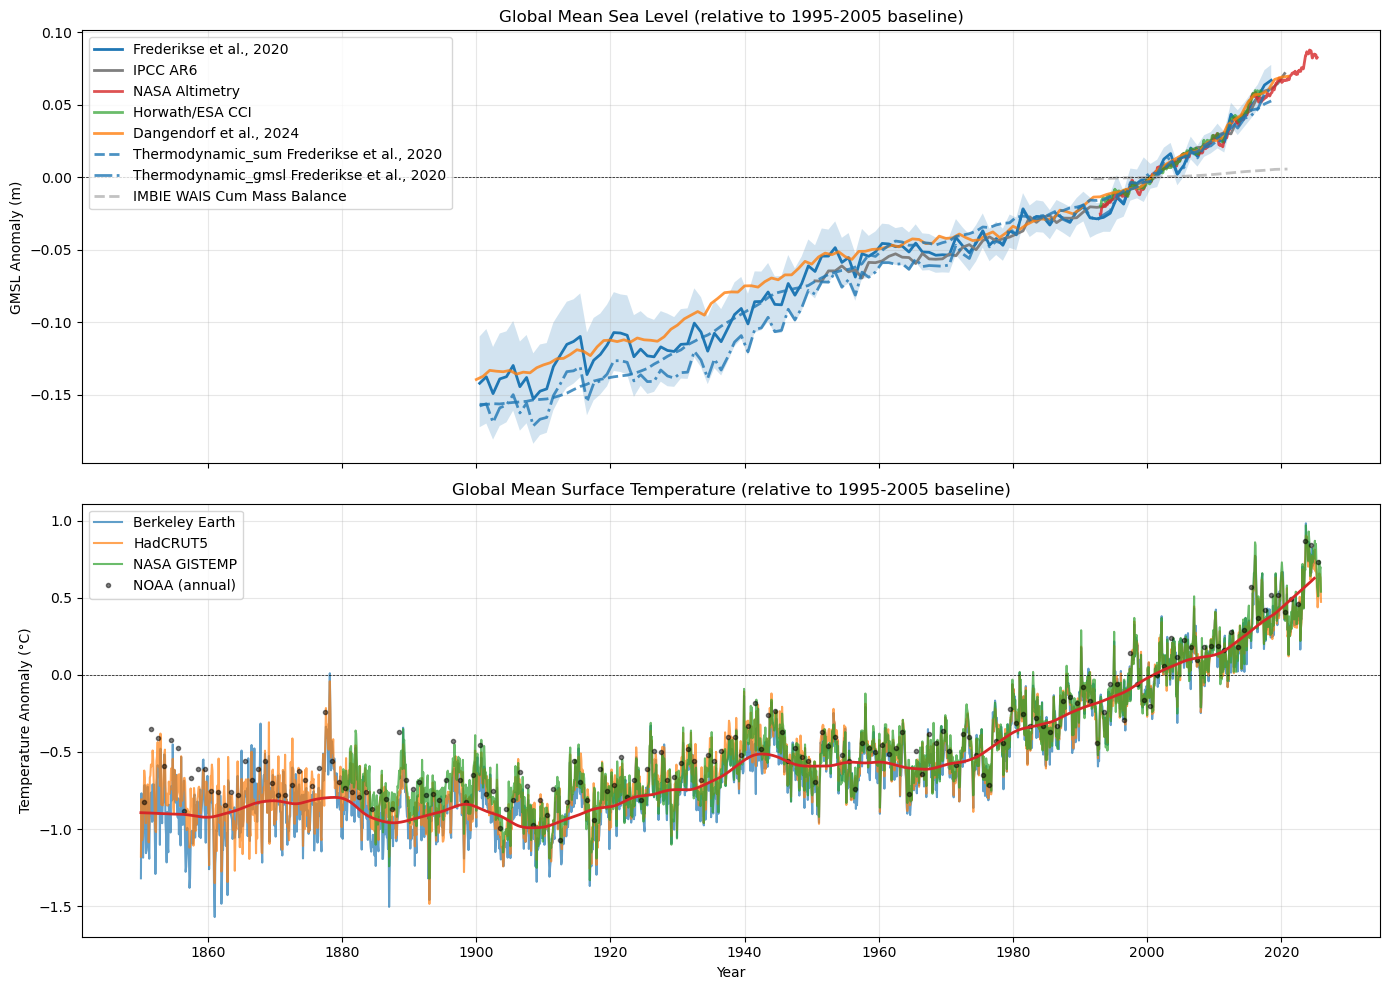

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# GMSL
ax1 = axes[0]
ax1.plot(df_frederikse_h.index, df_frederikse_h['gmsl'], 'tab:blue', lw=2, label='Frederikse et al., 2020')
ax1.fill_between(df_frederikse_h.index, df_frederikse_h['gmsl_lower'], df_frederikse_h['gmsl_upper'], alpha=0.2)
ax1.plot(df_ipcc_observed_gmsl_h.index, df_ipcc_observed_gmsl_h['gmsl'], 'tab:grey', lw=2, label='IPCC AR6')
ax1.plot(df_nasa_gmsl_h.index, df_nasa_gmsl_h['gmsl_smoothed'], 'tab:red', lw=2, label='NASA Altimetry', alpha=0.8)
ax1.plot(df_horwath_h.index, df_horwath_h['gmsl'], 'tab:green', lw=2, label='Horwath/ESA CCI', alpha=0.7)
ax1.plot(df_dangendorf_h.index, df_dangendorf_h['gmsl'],color='tab:orange', lw=2, label='Dangendorf et al., 2024', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_sum'], '--',color='tab:blue', lw=2, label='Thermodynamic_sum Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_gmsl'], '-.',color='tab:blue', lw=2, label='Thermodynamic_gmsl Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_imbie_wais_h.index, df_imbie_wais_h['cumulative_mass_balance'], '--',color='0.7', lw=2, label='IMBIE WAIS Cum Mass Balance', alpha=0.8)
ax1.axhline(0, color='k', lw=0.5, ls='--')
ax1.set_ylabel('GMSL Anomaly (m)')
ax1.set_title('Global Mean Sea Level (relative to 1995-2005 baseline)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Temperature
ax2 = axes[1]
ax2.plot(df_berkeley_h.index, df_berkeley_h['temperature'], label='Berkeley Earth', alpha=0.7)
ax2.plot(df_hadcrut_h.index, df_hadcrut_h['temperature'], label='HadCRUT5', alpha=0.7)
ax2.plot(df_gistemp_h.index, df_gistemp_h['temperature'], label='NASA GISTEMP', alpha=0.7)
ax2.plot(df_noaa_h.index, df_noaa_h['temperature'], 'ko', ms=3, label='NOAA (annual)', alpha=0.5)
ax2.plot(df_berkeley_h.index, sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.075)[:,1],'tab:red',lw=2)
ax2.axhline(0, color='k', lw=0.5, ls='--')
ax2.set_ylabel('Temperature Anomaly (°C)')
ax2.set_xlabel('Year')
ax2.set_title('Global Mean Surface Temperature (relative to 1995-2005 baseline)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/gmsl_gmst_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 SLR Cummulative, Rates, and Accelerations

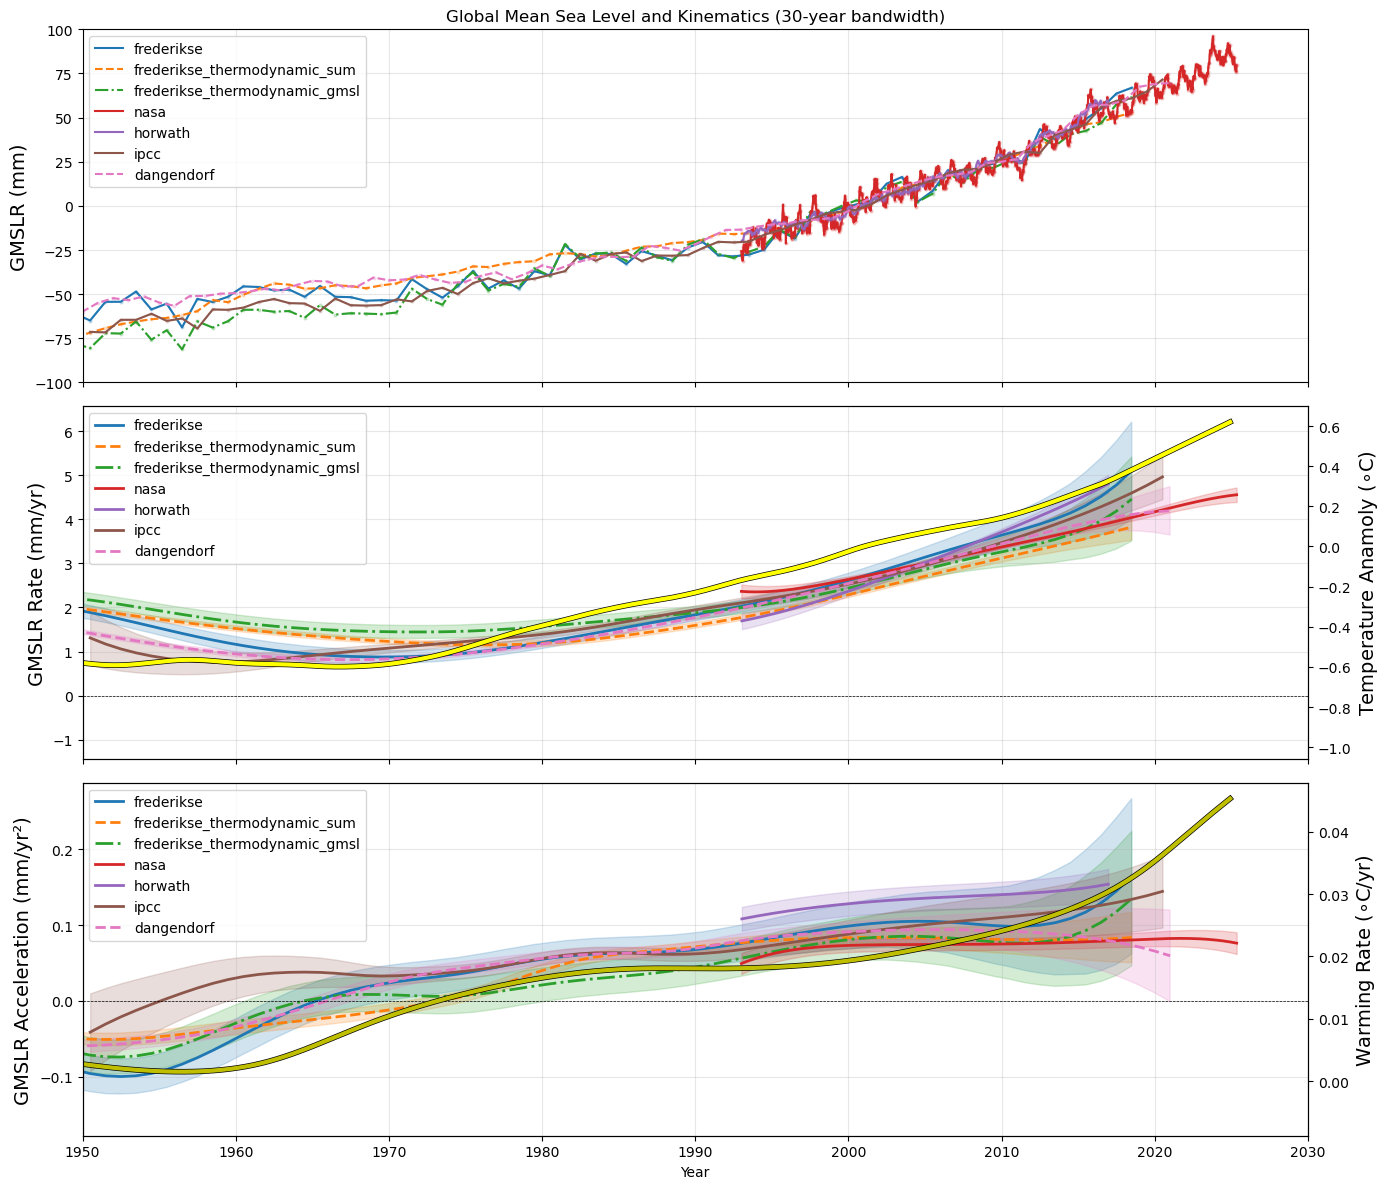

In [16]:
# -----------------------------------------------------------------------------
# PLOT: SLR Cummulative, Rates, and Accelerations
# -----------------------------------------------------------------------------

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
label_fontsize = 14

# Color scheme for datasets
colors = {
    'frederikse': 'C0',
    'frederikse_thermodynamic_sum' : 'C1',
    'frederikse_thermodynamic_gmsl' : 'C2',
    'nasa': 'C3', 
    'horwath': 'C4',
    'ipcc': 'C5',
    'dangendorf': 'C6'
}

linestyles = {
    'frederikse': '-',
    'frederikse_thermodynamic_sum' : '--',
    'frederikse_thermodynamic_gmsl' : '-.',
    'nasa': '-', 
    'horwath': '-',
    'ipcc': '-',
    'dangendorf': '--'
}

# ax1: GMSL data with fitted values
for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    
    # Get original data
    if name == 'frederikse':
        orig_df = df_frederikse_h
        plot_type = 'gmsl'
    elif name == 'frederikse_thermodynamic_sum':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_sum'
    elif name == 'frederikse_thermodynamic_gmsl':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_gmsl'
    elif name == 'nasa':
        orig_df = df_nasa_gmsl_h
        plot_type = 'gmsl'
    elif name == 'horwath':
        orig_df = df_horwath_h
        plot_type = 'gmsl'
    elif name == 'ipcc':
        orig_df = df_ipcc_observed_gmsl_h
        plot_type = 'gmsl'
    elif name == 'dangendorf':
        orig_df = df_dangendorf_h
        plot_type = 'gmsl'

    # Plot original data (light)
    ax1.plot(df['decimal_year'], orig_df[plot_type].values * 1000, 
             'o', color=colors[name], ls=linestyles[name], alpha=0.2, markersize=2)
    # Plot would need fitted values - using smoothed rate integration as proxy
    ax1.plot(df.loc[valid, 'decimal_year'], orig_df.loc[valid.values, plot_type].values * 1000,
             color=colors[name], ls=linestyles[name], linewidth=1.5, label=name)

ax1.set_ylabel('GMSLR (mm)',fontsize=label_fontsize)
ax1.set_title(f'Global Mean Sea Level and Kinematics ({SPAN_YEARS}-year bandwidth)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([1950,2030])
ax1.set_ylim([-100,100])

ax22 = ax2.twinx()
berkeley_lowess_smooth = sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.1)[:,1]
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'k',lw=4)
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'yellow',lw=3)
ax22.set_ylabel('Temperature Anamoly ($\\circ$C)',fontsize=label_fontsize)
    
# ax2: Rates
for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    rate_mm = df['rate'] * 1000
    rate_se_mm = df['rate_se'] * 1000
    
    ax2.plot(df.loc[valid, 'decimal_year'], rate_mm[valid], 
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax2.fill_between(df.loc[valid, 'decimal_year'], 
                     (rate_mm - 1.96*rate_se_mm)[valid],
                     (rate_mm + 1.96*rate_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax2.set_ylabel('GMSLR Rate (mm/yr)',fontsize=label_fontsize)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([1950,2030])

# ax3: Accelerations
ax33 = ax3.twinx()
df = gmst_kinematics_dfs['berkeley']
valid = ~np.isnan(df['rate'])
gmst_rate = df['rate']

ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='k',lw=4)
ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='y',lw=3, label='Berkeley Earth GMST')
ax33.set_ylabel('Warming Rate ($\\circ$C/yr)',fontsize=label_fontsize)

for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['accel'])
    accel_mm = df['accel'] * 1000
    accel_se_mm = df['accel_se'] * 1000
    
    ax3.plot(df.loc[valid, 'decimal_year'], accel_mm[valid],
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax3.fill_between(df.loc[valid, 'decimal_year'],
                     (accel_mm - 1.96*accel_se_mm)[valid],
                     (accel_mm + 1.96*accel_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax3.set_ylabel('GMSLR Acceleration (mm/yr²)',fontsize=label_fontsize)
ax3.set_xlabel('Year')
ax3.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([1950,2030])

plt.tight_layout()
plt.savefig('figures/gmsl_kinematics.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Rate vs. Temperature Phase Plot



In [1]:
# -----------------------------------------------------------------------------
# PLOT: Rate vs Temperature phase plot
# -----------------------------------------------------------------------------

# Resample Berkeley Earth to annual for matching
df_berkeley_annual = df_berkeley_h.resample('YE').mean()
df_berkeley_annual['decimal_year'] = df_berkeley_annual.index.year + 0.5

fig, axes = plt.subplots(2, 3, figsize=(22, 15))
axes = axes.flatten()

label_fontsize = 14

for i, (name, res) in enumerate(kinematics.items()):
    if i >= 6:
        break
    
    df_kin = kinematics_dfs[name]
    valid = ~np.isnan(df_kin['rate'])
    
    # Match time points with temperature
    kin_years = df_kin.loc[valid, 'decimal_year'].values
    rate_mm = df_kin.loc[valid, 'rate'].values * 1000
    
    # Find matching temperature values
    temp_matched = []
    rate_matched = []
    time_matched = []
    
    for year, rate in zip(kin_years, rate_mm):
        # Find closest temperature year
        temp_idx = np.argmin(np.abs(df_berkeley_annual['decimal_year'].values - year))
        if np.abs(df_berkeley_annual['decimal_year'].values[temp_idx] - year) < 1.0:
            temp_matched.append(df_berkeley_annual['temperature'].values[temp_idx])
            rate_matched.append(rate)
            time_matched.append(year)
    
    temp_matched = np.array(temp_matched)
    rate_matched = np.array(rate_matched)
    time_matched = np.array(time_matched)
    
    # Scatter plot colored by time
    sc = axes[i].scatter(temp_matched, rate_matched, c=time_matched, 
                         cmap='viridis', s=30, alpha=0.7)
    
    # Linear fit for α estimation
    if len(temp_matched) > 10:
        mask = ~(np.isnan(temp_matched) | np.isnan(rate_matched))
        if mask.sum() > 10:
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 2)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            #axes[i].plot(temp_range, p(temp_range), 'r--', linewidth=2, 
            #            label=f"{z[0]:.1f}$\\Delta T^2$ + {z[1]:.1f}$\\Delta T$...") #label=f'$\\alpha$ ≈ {z[1]:.1f} mm/yr/°C')
            sr = axes[i].scatter(temp_range, p(temp_range), c=np.gradient(p(temp_range),temp_range),
                            cmap='magma_r', s=30, alpha=0.7)
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 3)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            axes[i].plot(temp_range, p(temp_range), '--',color='0.7', linewidth=2) 
            #            label=f"{z[0]:.1f}$\\Delta T^3$ + {z[1]:.1f}$\\Delta T^2$ + {z[2]:.1f}$\\Delta T$...")

    axes[i].set_xlim([-1.5,0.75])
    axes[i].set_ylim([0,5])
    axes[i].set_xlabel('Temperature anomaly (°C)',fontsize=label_fontsize)
    axes[i].set_ylabel('GMSL rate (mm/yr)',fontsize=label_fontsize)
    axes[i].set_title(name,fontsize=label_fontsize)
    axes[i].grid(True, alpha=0.3)
    #axes[i].legend()

# Remove empty subplot if only 5 datasets
if len(kinematics) < 6:
    axes[-1].axis('off')
#print(plt.colorbar.__doc__)
plt.colorbar(sc, ax=axes, shrink=0.6, aspect=30, location='bottom', orientation='horizontal')
plt.colorbar(sr, ax=axes, shrink=1, aspect=30, label='$\\alpha$ (mm/yr/$\\circ$C)')
plt.suptitle('Global Mean Seal Level Rise Rate vs Global Mean Surface Temperature',fontsize=label_fontsize+2, y=0.95)
#plt.tight_layout()
plt.savefig('figures/rate_vs_temperature_phase.png', dpi=150, bbox_inches='tight')
plt.show()



NameError: name 'df_berkeley_h' is not defined

---
## Data Summary

In [18]:
summary = pd.DataFrame({
    'Dataset': ['Frederikse', 'NASA Altimetry', 'Horwath/ESA', 'IMBIE WAIS', 'Berkeley', 'HadCRUT5', 'GISTEMP', 'NOAA'],
    'Type': ['GMSL', 'GMSL', 'GMSL', 'GMSL', 'Temp', 'Temp', 'Temp', 'Temp'],
    'Start': ['1900', '1993', '1993', '1992', '1850', '1850', '1880', '1850'],
    'End': ['2018', '2025', '2016', '2022','2024', '2025', '2025', '2025'],
    'Resolution': ['Annual', '10-day', 'Monthly', 'Monthly', 'Monthly', 'Monthly', 'Monthly', 'Annual'],
    'Has Uncertainty': [True, True, True, True, True, True, False, False]
})
print(summary.to_string(index=False))

       Dataset Type Start  End Resolution  Has Uncertainty
    Frederikse GMSL  1900 2018     Annual             True
NASA Altimetry GMSL  1993 2025     10-day             True
   Horwath/ESA GMSL  1993 2016    Monthly             True
    IMBIE WAIS GMSL  1992 2022    Monthly             True
      Berkeley Temp  1850 2024    Monthly             True
      HadCRUT5 Temp  1850 2025    Monthly             True
       GISTEMP Temp  1880 2025    Monthly            False
          NOAA Temp  1850 2025     Annual            False


---

## Fit dynamic sensitivity 


### 1. Statistical tests for quadratic vs linear fits 

In [19]:
#####
# Test robustness of quadratic and linear fits

from slr_analysis import test_rate_temperature_nonlinearity

# Get rate from kinematics
df_kin = kinematics_dfs['frederikse']
valid = ~np.isnan(df_kin['rate'])

rate = df_kin.loc[valid, 'rate'].values * 1000  # mm/yr
rate_se = df_kin.loc[valid, 'rate_se'].values * 1000

# Get corresponding temperatures (need to align by year)
years = df_kin.loc[valid, 'decimal_year'].values
temp = np.interp(years, get_decimal_year(df_berkeley_h), df_berkeley_h['temperature'])

# Run diagnostic
result = test_rate_temperature_nonlinearity(rate, temp, rate_sigma=rate_se)

# Print results
print('Frederikse')
print(result['recommendation'])
print(f"\nLinear:    rate = {result['linear']['coeffs'][0]:.2f}×T + {result['linear']['coeffs'][1]:.2f}")
print(f"Quadratic: rate = {result['quadratic']['coeffs'][0]:.2f}×T² + {result['quadratic']['coeffs'][1]:.2f}×T + {result['quadratic']['coeffs'][2]:.2f}")
print(f"\nF-test: F={result['f_test']['f_stat']:.2f}, p={result['f_test']['p_value']:.4f}")
print(f"R² linear: {result['linear']['r2']:.3f}, R² quadratic: {result['quadratic']['r2']:.3f}")

df_kin = kinematics_dfs['ipcc']
valid = ~np.isnan(df_kin['rate'])

rate = df_kin.loc[valid, 'rate'].values * 1000  # mm/yr
rate_se = df_kin.loc[valid, 'rate_se'].values * 1000

# Get corresponding temperatures (need to align by year)
years = df_kin.loc[valid, 'decimal_year'].values
temp = np.interp(years, get_decimal_year(df_berkeley_h), df_berkeley_h['temperature'])

# Run diagnostic
result = test_rate_temperature_nonlinearity(rate, temp, rate_sigma=rate_se)

print('\n\nIPCC')
print(result['recommendation'])
print(f"\nLinear:    rate = {result['linear']['coeffs'][0]:.2f}×T + {result['linear']['coeffs'][1]:.2f}")
print(f"Quadratic: rate = {result['quadratic']['coeffs'][0]:.2f}×T² + {result['quadratic']['coeffs'][1]:.2f}×T + {result['quadratic']['coeffs'][2]:.2f}")
print(f"\nF-test: F={result['f_test']['f_stat']:.2f}, p={result['f_test']['p_value']:.4f}")
print(f"R² linear: {result['linear']['r2']:.3f}, R² quadratic: {result['quadratic']['r2']:.3f}")

Frederikse
QUADRATIC model preferred. F-test significant (p=0.0001); AIC favors quadratic (ΔAIC=14.8); BIC favors quadratic (ΔBIC=12.0); R² improvement: 0.0777 (0.408 → 0.486)

Linear:    rate = 1.52×T + 2.35
Quadratic: rate = 2.10×T² + 3.25×T + 2.56

F-test: F=17.55, p=0.0001
R² linear: 0.408, R² quadratic: 0.486


IPCC
QUADRATIC model preferred. F-test significant (p=0.0015); AIC favors quadratic (ΔAIC=8.6); BIC favors quadratic (ΔBIC=6.3); R² improvement: 0.0357 (0.741 → 0.777)

Linear:    rate = 2.67×T + 2.72
Quadratic: rate = 2.35×T² + 3.99×T + 2.74

F-test: F=10.90, p=0.0015
R² linear: 0.741, R² quadratic: 0.777


### 3. Fit quadtraic alpha using DLS framework

In [20]:
# Calibrate quadratic model
from slr_analysis import calibrate_alpha_dols_quadratic

result = calibrate_alpha_dols_quadratic(
    sea_level=df_frederikse_h['gmsl'],
    temperature=df_berkeley_h['temperature'],
    n_lags=2
)

print(result)
# DOLSQuadraticResult(
#   α₀ = 3.25 ± 0.XX (linear sensitivity)
#   dα/dT = 2.10 ± 0.XX (quadratic sensitivity)
#   trend = 0.00XX ± 0.00XX
#   R² = 0.XXX, R²_adj = 0.XXX
#   ...
# )

# Predict rate at different temperatures
T_future = np.array([1.0, 1.5, 2.0, 3.0, 4.0])
rates = result.predict_rate(T_future)
rate_lo, rate_hi = result.predict_rate_ci(T_future)

for t, r, lo, hi in zip(T_future, rates, rate_lo, rate_hi):
    print(f"T={t:.1f}°C: rate = {1000*r:.1f} [{1000*lo:.1f}, {1000*hi:.1f}] mm/yr")

DOLSQuadraticResult(
  α₀ = 0.004 ± 0.001 (linear sensitivity)
  dα/dT = 0.006 ± 0.003 (quadratic sensitivity)
  trend = 0.0026 ± 0.0002
  R² = 0.969, R²_adj = 0.966
  AIC = -732.6, BIC = -707.9
  n_obs = 115, n_lags = 2
)
T=1.0°C: rate = 13.1 [5.0, 21.2] mm/yr
T=1.5°C: rate = 23.2 [7.1, 39.3] mm/yr
T=2.0°C: rate = 36.5 [9.6, 63.4] mm/yr
T=3.0°C: rate = 72.8 [16.3, 129.4] mm/yr
T=4.0°C: rate = 122.0 [24.9, 219.2] mm/yr


---
## 7. Sea Level Projections to 2100

Project GMSL to 2100 using the calibrated quadratic rate–temperature relationship from the DOLS fit above, driven by IPCC AR6 temperature projections for SSP1-2.6, SSP2-4.5, and SSP5-8.5.

**Model:** $\frac{d(\text{GMSL})}{dt} = \frac{d\alpha}{dT} T^2 + \alpha_0 T + c$

**Uncertainty:** 90% confidence interval (5th–95th percentile) from 1000-member Monte Carlo ensemble sampling the coefficient covariance matrix, propagated through IPCC temperature uncertainty.

**Reference points:** IPCC AR6 WG1 Chapter 9 projected GMSL (Fox-Kemper et al., 2021).

Temperature offset (1850-1900 → 1995-2005): 0.726 °C


DOLS coefficients [dα/dT, α₀, trend] (mm/yr): [6.45, 4.05, 2.58]


Trend extrapolation (1993-2020 quadratic):
  accel = 0.111 mm/yr², rate@2005 = 2.93 mm/yr
  At 2100: 788 [647, 929] mm


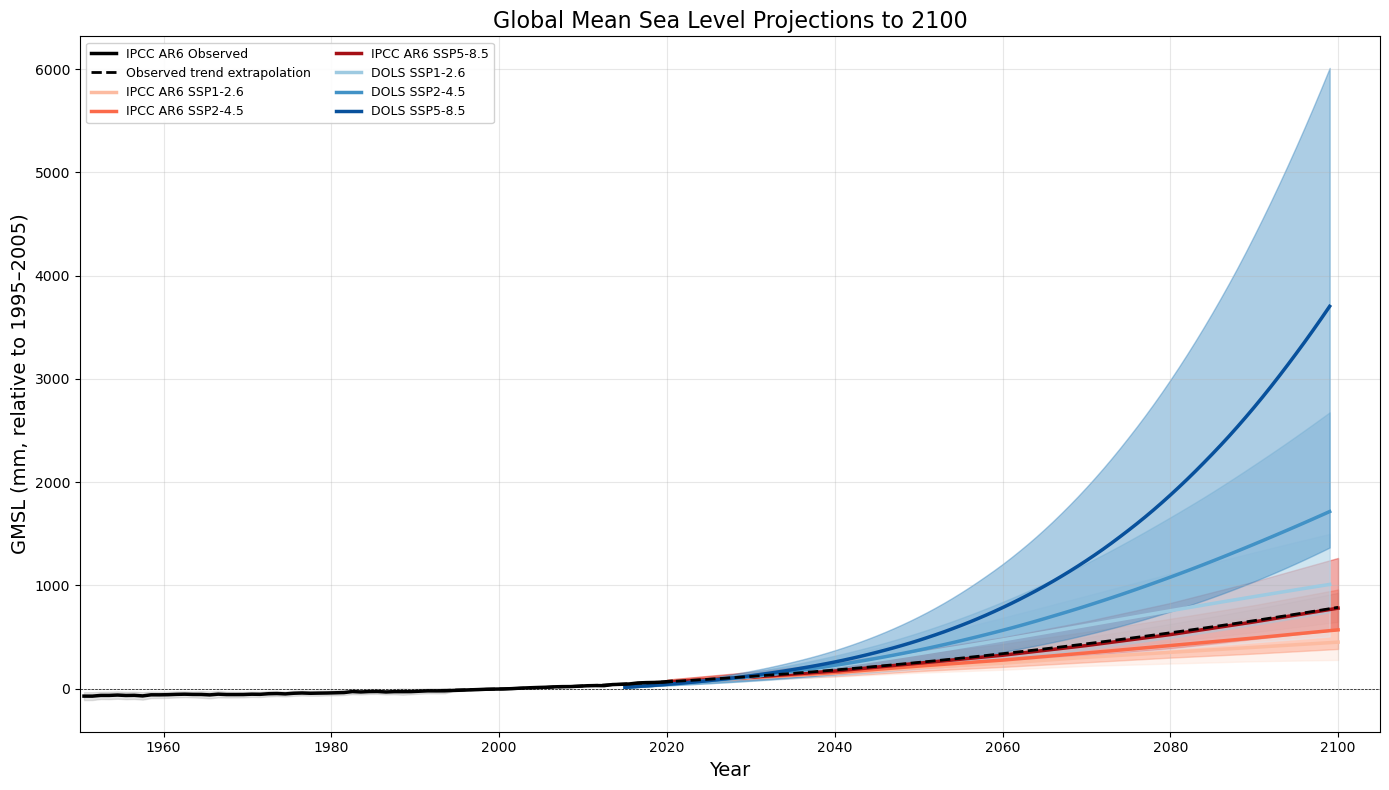


Scenario         IPCC AR6 2100 (mm)           DOLS model 2100 (mm)        
SSP1-2.6           451 [  279,   789]        1010 [  506,  1499]
SSP2-4.5           570 [  385,   960]        1716 [  740,  2676]
SSP5-8.5           780 [  569,  1266]        3703 [ 1367,  6011]
Trend extrap.      788 [  647,   929]


In [21]:
# [PROJ-PLOT] -----------------------------------------------------------------
# Sea Level Projections to 2100 with 90% CI
# -----------------------------------------------------------------------------

from slr_data_readers import read_ipcc_ar6_projected_temperature, read_ipcc_ar6_projected_gmsl
from slr_projections import project_gmsl_ensemble

# =============================================================================
# 1. Load IPCC AR6 temperature projections and re-baseline
# =============================================================================
DATA_IPCC_DIR = DATA_RAW_DIR / 'ipcc_ar6'
temp_projections = read_ipcc_ar6_projected_temperature(DATA_IPCC_DIR / 'atmo_temp')

# Re-baseline temperatures from 1850-1900 to 1995-2005
df_hist_temp = temp_projections['Historical']
baseline_offset = df_hist_temp.loc[
    (df_hist_temp['decimal_year'] >= 1995) & (df_hist_temp['decimal_year'] <= 2005),
    'temperature'
].mean()
print(f"Temperature offset (1850-1900 → 1995-2005): {baseline_offset:.3f} °C")

ssp_scenarios = {}
for scenario in ['SSP1_2_6', 'SSP2_4_5', 'SSP5_8_5']:
    df_ssp = temp_projections[scenario].copy()
    df_ssp['temperature'] -= baseline_offset
    df_ssp['temperature_lower'] -= baseline_offset
    df_ssp['temperature_upper'] -= baseline_offset
    ssp_scenarios[scenario] = df_ssp

# =============================================================================
# 2. DOLS model-based projections (blue family)
# =============================================================================
# DOLS coefficients are in meters; convert to mm for projection
coeffs_m = np.array([result.dalpha_dT, result.alpha0, result.trend])  # m/yr
coeffs_mm = coeffs_m * 1000  # mm/yr

# Transform covariance from DOLS parameterization (coeff[0]=dalpha_dT/2)
# and convert from m to mm (multiply by 1000²)
cov_full = result.covariance
cov_3x3_m = np.zeros((3, 3))
cov_3x3_m[0, 0] = 4 * cov_full[0, 0]
cov_3x3_m[0, 1] = 2 * cov_full[0, 1]
cov_3x3_m[0, 2] = 2 * cov_full[0, 2]
cov_3x3_m[1, 0] = cov_3x3_m[0, 1]
cov_3x3_m[1, 1] = cov_full[1, 1]
cov_3x3_m[1, 2] = cov_full[1, 2]
cov_3x3_m[2, 0] = cov_3x3_m[0, 2]
cov_3x3_m[2, 1] = cov_3x3_m[1, 2]
cov_3x3_m[2, 2] = cov_full[2, 2]
cov_3x3_mm = cov_3x3_m * (1000**2)  # m² → mm²

# Baseline GMSL at 2005 in mm (1995-2005 baseline)
baseline_year = 2005.0
baseline_gmsl_mm = df_ipcc_observed_gmsl_h.loc['2005', 'gmsl'].values[0] * 1000

proj_results = project_gmsl_ensemble(
    coefficients=coeffs_mm,
    coefficients_cov=cov_3x3_mm,
    temperature_projections=ssp_scenarios,
    baseline_year=baseline_year,
    baseline_gmsl=baseline_gmsl_mm,
    n_samples=1000,
    seed=42,
)
print(f"DOLS coefficients [dα/dT, α₀, trend] (mm/yr): [{coeffs_mm[0]:.2f}, {coeffs_mm[1]:.2f}, {coeffs_mm[2]:.2f}]")

# =============================================================================
# 3. IPCC AR6 FACTS projections (red family)
# =============================================================================
ipcc_gmsl_proj = read_ipcc_ar6_projected_gmsl(
    DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'
)

# FACTS projections are relative to 2005; shift to 1995-2005 baseline
ipcc_baseline_shift = baseline_gmsl_mm  # observed GMSL at 2005 in our baseline (mm)

# =============================================================================
# 4. Observed trend extrapolation (dashed black)
# =============================================================================
# Use IPCC observed GMSL: fit quadratic (constant acceleration) over 1993-2020
obs_years = get_decimal_year(df_ipcc_observed_gmsl_h)
obs_gmsl_mm = df_ipcc_observed_gmsl_h['gmsl'].values * 1000
obs_sigma_mm = df_ipcc_observed_gmsl_h['gmsl_sigma'].values * 1000

# Fit over satellite era (1993-2020) for the most recent trend
sat_mask = obs_years >= 1993
t_sat = obs_years[sat_mask]
y_sat = obs_gmsl_mm[sat_mask]
s_sat = obs_sigma_mm[sat_mask]

# Weighted quadratic fit: GMSL = a*(t-t0)^2 + b*(t-t0) + c
t0_extrap = 2005.0
dt_sat = t_sat - t0_extrap
weights = 1.0 / s_sat**2
# Build weighted design matrix
A = np.column_stack([dt_sat**2, dt_sat, np.ones_like(dt_sat)])
W = np.diag(weights)
AtWA = A.T @ W @ A
AtWy = A.T @ W @ y_sat
p_extrap = np.linalg.solve(AtWA, AtWy)  # [a, b, c]
cov_extrap = np.linalg.inv(AtWA)  # covariance of [a, b, c]

# Extrapolate to 2100
t_future = np.arange(1993, 2101, 1.0)
dt_future = t_future - t0_extrap
A_future = np.column_stack([dt_future**2, dt_future, np.ones_like(dt_future)])
extrap_gmsl = A_future @ p_extrap

# 90% CI via prediction variance: var(y) = A @ cov @ A.T diagonal
extrap_var = np.sum((A_future @ cov_extrap) * A_future, axis=1)
z90 = 1.645
extrap_lower = extrap_gmsl - z90 * np.sqrt(extrap_var)
extrap_upper = extrap_gmsl + z90 * np.sqrt(extrap_var)

print(f"Trend extrapolation (1993-2020 quadratic):")
print(f"  accel = {2*p_extrap[0]:.3f} mm/yr², rate@2005 = {p_extrap[1]:.2f} mm/yr")
print(f"  At 2100: {extrap_gmsl[-1]:.0f} [{extrap_lower[-1]:.0f}, {extrap_upper[-1]:.0f}] mm")

# =============================================================================
# 5. Plot
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 8))
label_fontsize = 14

# --- Observed GMSL ---
ax.plot(obs_years, obs_gmsl_mm, 'k-', lw=2.5, label='IPCC AR6 Observed', zorder=10)
ax.fill_between(obs_years,
                (obs_gmsl_mm - 1.645 * obs_sigma_mm),
                (obs_gmsl_mm + 1.645 * obs_sigma_mm),
                color='k', alpha=0.1)

# --- Trend extrapolation (dashed black) ---
ax.plot(t_future, extrap_gmsl, 'k--', lw=2, label='Observed trend extrapolation', zorder=9)
ax.fill_between(t_future, extrap_lower, extrap_upper, color='k', alpha=0.08)

# --- IPCC FACTS projections (red family) ---
ipcc_red_colors = {
    'ssp126': '#fee0d2',  # lightest
    'ssp245': '#fc9272',
    'ssp585': '#de2d26',  # darkest
}
ipcc_labels = {
    'ssp126': 'IPCC AR6 SSP1-2.6',
    'ssp245': 'IPCC AR6 SSP2-4.5',
    'ssp585': 'IPCC AR6 SSP5-8.5',
}
ipcc_line_colors = {
    'ssp126': '#fcbba1',
    'ssp245': '#fb6a4a',
    'ssp585': '#a50f15',
}

for ssp in ['ssp126', 'ssp245', 'ssp585']:
    df_ip = ipcc_gmsl_proj[ssp]
    ip_years = df_ip['decimal_year'].values
    ip_gmsl = df_ip['gmsl'].values * 1000 + ipcc_baseline_shift  # mm, shifted
    ip_lower = df_ip['gmsl_lower'].values * 1000 + ipcc_baseline_shift
    ip_upper = df_ip['gmsl_upper'].values * 1000 + ipcc_baseline_shift

    # Only plot up to 2100
    mask_2100 = ip_years <= 2100
    ax.plot(ip_years[mask_2100], ip_gmsl[mask_2100], '-', color=ipcc_line_colors[ssp],
            lw=2.5, label=ipcc_labels[ssp])
    ax.fill_between(ip_years[mask_2100], ip_lower[mask_2100], ip_upper[mask_2100],
                    color=ipcc_red_colors[ssp], alpha=0.4)

# --- DOLS model projections (blue family) ---
dols_blue_colors = {
    'SSP1_2_6': '#deebf7',  # lightest
    'SSP2_4_5': '#9ecae1',
    'SSP5_8_5': '#3182bd',  # darkest
}
dols_line_colors = {
    'SSP1_2_6': '#9ecae1',
    'SSP2_4_5': '#4292c6',
    'SSP5_8_5': '#08519c',
}
dols_labels = {
    'SSP1_2_6': 'DOLS SSP1-2.6',
    'SSP2_4_5': 'DOLS SSP2-4.5',
    'SSP5_8_5': 'DOLS SSP5-8.5',
}

for scenario in ['SSP1_2_6', 'SSP2_4_5', 'SSP5_8_5']:
    df_proj = proj_results['scenarios'][scenario]
    years = df_proj['decimal_year'].values
    mask_2100 = years <= 2100

    ax.plot(years[mask_2100], df_proj['gmsl'].values[mask_2100], '-',
            color=dols_line_colors[scenario], lw=2.5, label=dols_labels[scenario])
    ax.fill_between(years[mask_2100],
                    df_proj['gmsl_lower'].values[mask_2100],
                    df_proj['gmsl_upper'].values[mask_2100],
                    color=dols_blue_colors[scenario], alpha=0.4)

# --- Axis formatting ---
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_xlabel('Year', fontsize=label_fontsize)
ax.set_ylabel('GMSL (mm, relative to 1995–2005)', fontsize=label_fontsize)
ax.set_title('Global Mean Sea Level Projections to 2100', fontsize=label_fontsize + 2)
ax.set_xlim([1950, 2105])
ax.legend(loc='upper left', fontsize=9, ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/gmsl_projections_2100.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# Summary table
# =============================================================================
print(f"\n{'':=<80}")
print(f"{'Scenario':<16} {'IPCC AR6 2100 (mm)':<28} {'DOLS model 2100 (mm)':<28}")
print(f"{'':=<80}")
for ssp, scenario in [('ssp126', 'SSP1_2_6'), ('ssp245', 'SSP2_4_5'), ('ssp585', 'SSP5_8_5')]:
    ssp_label = {'ssp126': 'SSP1-2.6', 'ssp245': 'SSP2-4.5', 'ssp585': 'SSP5-8.5'}[ssp]
    # IPCC
    df_ip = ipcc_gmsl_proj[ssp]
    row = df_ip[df_ip['decimal_year'] == 2100].iloc[0]
    ip = row['gmsl'] * 1000 + ipcc_baseline_shift
    ip_lo = row['gmsl_lower'] * 1000 + ipcc_baseline_shift
    ip_hi = row['gmsl_upper'] * 1000 + ipcc_baseline_shift
    # DOLS
    df_d = proj_results['scenarios'][scenario]
    idx = np.argmin(np.abs(df_d['decimal_year'].values - 2100))
    d = df_d['gmsl'].iloc[idx]
    d_lo = df_d['gmsl_lower'].iloc[idx]
    d_hi = df_d['gmsl_upper'].iloc[idx]
    print(f"{ssp_label:<16} {ip:>5.0f} [{ip_lo:>5.0f}, {ip_hi:>5.0f}]       {d:>5.0f} [{d_lo:>5.0f}, {d_hi:>5.0f}]")

print(f"{'Trend extrap.':<16} {extrap_gmsl[-1]:>5.0f} [{extrap_lower[-1]:>5.0f}, {extrap_upper[-1]:>5.0f}]")
print(f"{'':=<80}")

2050 SSP1-2.6: IPCC ~ N(217, 47) [141, 294] mm (90% CI)  |  DOLS = 344 [188, 501] mm
2050 SSP2-4.5: IPCC ~ N(233, 47) [155, 310] mm (90% CI)  |  DOLS = 380 [200, 559] mm
2050 Trend: 255 [226, 284] mm

2075 SSP1-2.6: IPCC ~ N(354, 93) [201, 507] mm (90% CI)  |  DOLS = 695 [351, 1036] mm
2075 SSP2-4.5: IPCC ~ N(408, 100) [244, 572] mm (90% CI)  |  DOLS = 953 [437, 1463] mm
2075 Trend: 487 [414, 562] mm

2100 SSP1-2.6: IPCC ~ N(484, 152) [234, 734] mm (90% CI)  |  DOLS = 1026 [506, 1541] mm
2100 SSP2-4.5: IPCC ~ N(613, 171) [333, 894] mm (90% CI)  |  DOLS = 1748 [739, 2739] mm
2100 Trend: 787 [651, 931] mm



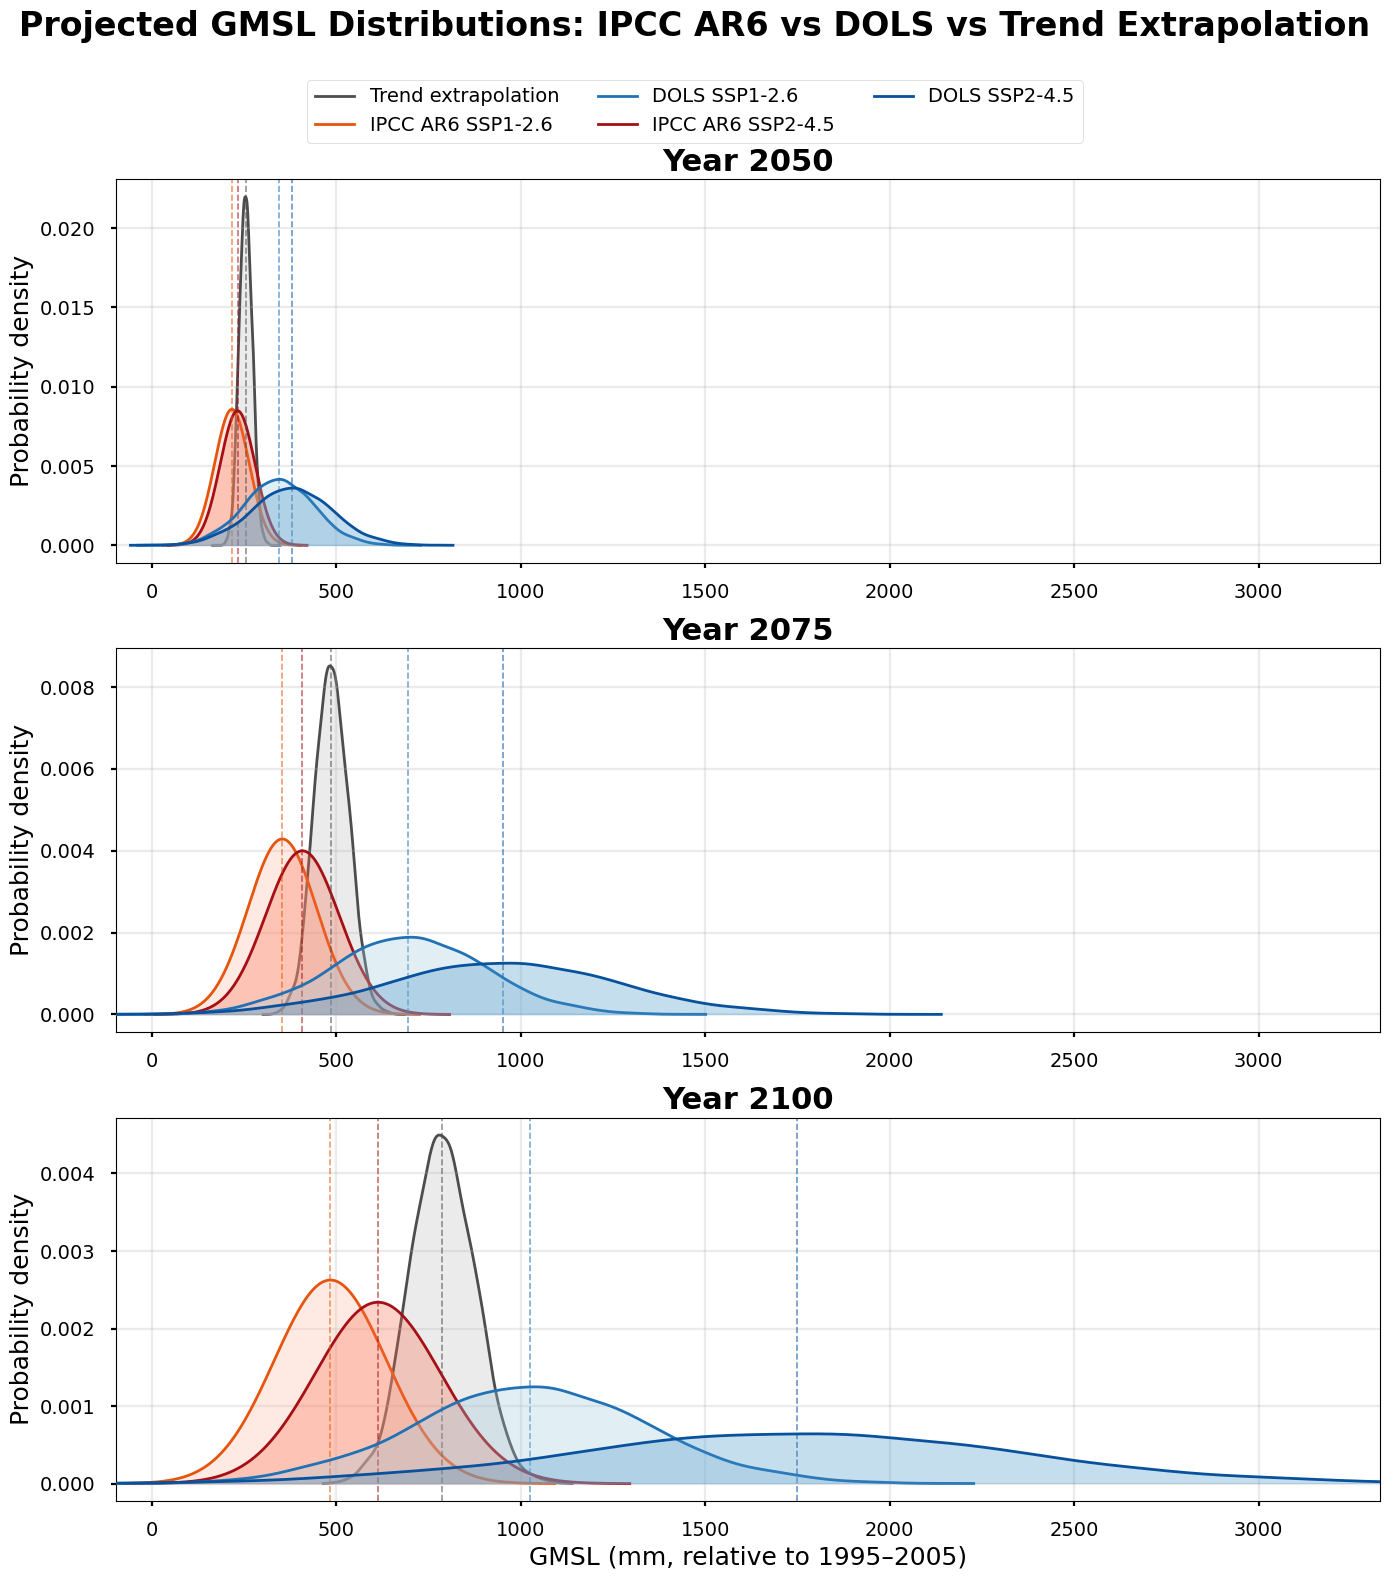

In [22]:
# [PROJ-HIST] -------------------------------------------------------------------
# Histograms of projected GMSL at user-defined years
# Compares IPCC AR6 FACTS (red), DOLS model (blue), trend extrapolation (grey)
# for SSP1-2.6 and SSP2-4.5 scenarios
# ------------------------------------------------------------------------------
#
# TODO: The IPCC FACTS medium-confidence quantile files contain a p-box artefact
#       (discrete jump at the median from combining pb_1e and pb_1f expert-
#       judgment distributions).  Here we approximate each scenario/year as a
#       Gaussian fitted to the 17th–83rd percentile range.  This is adequate for
#       visualization but discards the heavy upper tail.
#
#       For a proper treatment, search the FACTS processing scripts in:
#           BASE_DIR/data/raw/ipcc_ar6/slr/ar6/scripts/
#       Key files to examine:
#           - convert_samples_to_dist.py    (samples → quantile distributions)
#           - generate_pbox_components.py   (p-box combination logic)
#           - generate_confidence_output_files.py (confidence-level aggregation)
#           - sample_from_quantiles.py      (quantile → sample inversion)
#       These may provide access to the underlying Monte Carlo samples before
#       the p-box merge, which would give smooth per-component PDFs that can
#       be combined without the median discontinuity.
# ------------------------------------------------------------------------------
import xarray as xr
from scipy.stats import norm, gaussian_kde

target_years = [2050, 2075, 2100]

# =============================================================================
# 1. Build IPCC AR6 FACTS Gaussian approximations at target years
#
#    The raw quantile function has a discrete jump at q = 0.50 from the p-box
#    combination (lower half from pb_1e, upper half from pb_1f).  Rather than
#    attempting a splice, we fit a Gaussian using robust quantile-based
#    estimators that are unaffected by the median artefact:
#
#        mu    = midpoint of the 17th–83rd percentile ("likely") range
#        sigma = (q83 – q17) / (2 × 0.9674)       [z_{0.833} ≈ 0.9674]
#
#    This preserves the IPCC "likely" range exactly and gives a symmetric
#    PDF that is a reasonable approximation for the bulk of the distribution.
# =============================================================================
ipcc_facts_dir = DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'

Z_83 = 0.9674   # normal z-score at q = 0.833

ipcc_gauss_params = {}       # dict[ssp][yr] → (mu, sigma) in mm
ipcc_quantile_axes = {}      # dict[ssp] → raw quantile axis
ipcc_raw_quantile_vals = {}  # dict[ssp][yr] → raw 107-point quantile values (mm)

for ssp in ['ssp126', 'ssp245']:
    total_nc = ipcc_facts_dir / ssp / f'total_{ssp}_medium_confidence_values.nc'
    ds = xr.open_dataset(total_nc)
    sl = ds['sea_level_change'].values[:, :, 0]  # (quantiles, years), mm
    quantiles = ds['quantiles'].values
    years_nc = ds['years'].values
    ds.close()

    ipcc_quantile_axes[ssp] = quantiles
    ipcc_gauss_params[ssp] = {}
    ipcc_raw_quantile_vals[ssp] = {}

    i_q17 = np.argmin(np.abs(quantiles - 0.167))
    i_q83 = np.argmin(np.abs(quantiles - 0.833))

    for yr in target_years:
        # Interpolate between decadal time steps if needed (e.g. 2075)
        yr_lo_idx = np.searchsorted(years_nc, yr, side='right') - 1
        yr_lo_idx = max(0, min(yr_lo_idx, len(years_nc) - 2))
        yr_lo, yr_hi = years_nc[yr_lo_idx], years_nc[yr_lo_idx + 1]

        if yr_lo == yr:
            vals_mm = sl[:, yr_lo_idx].copy()
        else:
            frac = (yr - yr_lo) / (yr_hi - yr_lo)
            vals_mm = (sl[:, yr_lo_idx] * (1 - frac)
                       + sl[:, yr_lo_idx + 1] * frac)

        # Shift from 2005-relative to 1995-2005 baseline
        vals_mm = vals_mm + ipcc_baseline_shift
        ipcc_raw_quantile_vals[ssp][yr] = vals_mm.copy()

        # Fit Gaussian from 17th–83rd percentile range
        v17 = vals_mm[i_q17]
        v83 = vals_mm[i_q83]
        sigma = (v83 - v17) / (2 * Z_83)
        mu = 0.5 * (v17 + v83)
        ipcc_gauss_params[ssp][yr] = (mu, sigma)

# =============================================================================
# 2. Build DOLS model full ensemble distributions at target years
# =============================================================================
np.random.seed(42)
n_mc = 5000
coeff_draws = np.random.multivariate_normal(coeffs_mm, cov_3x3_mm, n_mc)

dols_ensemble_samples = {}
for scenario, ssp_label in [('SSP1_2_6', 'SSP1-2.6'), ('SSP2_4_5', 'SSP2-4.5')]:
    temp_df = ssp_scenarios[scenario]
    T = temp_df['temperature'].values
    time_yrs = temp_df['decimal_year'].values
    dt_arr = np.diff(time_yrs)
    b_idx = np.argmin(np.abs(time_yrs - baseline_year))

    gmsl_ens = np.zeros((n_mc, len(T)))
    for k, (a_k, b_k, c_k) in enumerate(coeff_draws):
        rate_k = a_k * T**2 + b_k * T + c_k
        g = np.zeros(len(T))
        g[b_idx] = baseline_gmsl_mm
        for i in range(b_idx, len(T) - 1):
            g[i + 1] = g[i] + 0.5 * (rate_k[i] + rate_k[i + 1]) * dt_arr[i]
        for i in range(b_idx, 0, -1):
            g[i - 1] = g[i] - 0.5 * (rate_k[i] + rate_k[i - 1]) * dt_arr[i - 1]
        gmsl_ens[k] = g

    dols_ensemble_samples[scenario] = {}
    for yr in target_years:
        yr_idx = np.argmin(np.abs(time_yrs - yr))
        dols_ensemble_samples[scenario][yr] = gmsl_ens[:, yr_idx]

# =============================================================================
# 3. Build trend extrapolation ensemble at target years
# =============================================================================
n_trend = 5000
np.random.seed(123)
p_draws = np.random.multivariate_normal(p_extrap, cov_extrap, n_trend)

trend_ensemble_samples = {}
for yr in target_years:
    dt_yr = yr - t0_extrap
    A_yr = np.array([dt_yr**2, dt_yr, 1.0])
    trend_ensemble_samples[yr] = p_draws @ A_yr  # mm

# =============================================================================
# 4. Plot — vertically stacked smooth KDE / Gaussian distributions
# =============================================================================
with plt.style.context('seaborn-v0_8-poster'):

    TITLE_FS = 22
    LABEL_FS = 18
    TICK_FS = 14
    LEGEND_FS = 14
    ANNOT_FS = 12

    ssp_pairs = [
        ('ssp126', 'SSP1_2_6', 'SSP1-2.6'),
        ('ssp245', 'SSP2_4_5', 'SSP2-4.5'),
    ]

    # Color assignments matching cell 45 [PROJ-PLOT]
    ipcc_fill_colors = {'ssp126': '#fcbba1', 'ssp245': '#fb6a4a'}
    ipcc_line_colors = {'ssp126': '#e6550d', 'ssp245': '#a50f15'}
    dols_fill_colors = {'SSP1_2_6': '#9ecae1', 'SSP2_4_5': '#4292c6'}
    dols_line_colors = {'SSP1_2_6': '#2171b5', 'SSP2_4_5': '#08519c'}
    trend_fill_color = '0.75'
    trend_line_color = '0.30'

    fig, axes = plt.subplots(len(target_years), 1,
                             figsize=(14, 5 * len(target_years)),
                             sharex=False)

    # Global x-range across all panels
    all_bounds = []
    for yr in target_years:
        all_bounds.extend(np.percentile(trend_ensemble_samples[yr], [0.5, 99.5]))
        for ssp, dk, _ in ssp_pairs:
            mu, sig = ipcc_gauss_params[ssp][yr]
            all_bounds.extend([mu - 3.5 * sig, mu + 3.5 * sig])
            all_bounds.extend(np.percentile(dols_ensemble_samples[dk][yr], [0.5, 99.5]))
    x_lo = min(all_bounds)
    x_hi = max(all_bounds)

    for row, (ax, yr) in enumerate(zip(axes, target_years)):

        # --- Trend extrapolation: smooth KDE ---
        trend_vals = trend_ensemble_samples[yr]
        kde_trend = gaussian_kde(trend_vals, bw_method='silverman')
        x_trend = np.linspace(trend_vals.min() - 30, trend_vals.max() + 30, 500)
        pdf_trend = kde_trend(x_trend)
        ax.fill_between(x_trend, pdf_trend, alpha=0.30, color=trend_fill_color,
                        zorder=1)
        ax.plot(x_trend, pdf_trend, color=trend_line_color, lw=2.0,
                label='Trend extrapolation', zorder=1)

        for ssp, dols_key, label in ssp_pairs:

            # --- IPCC FACTS: Gaussian approximation ---
            mu, sigma = ipcc_gauss_params[ssp][yr]
            x_gauss = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
            pdf_gauss = norm.pdf(x_gauss, loc=mu, scale=sigma)

            ax.fill_between(x_gauss, pdf_gauss, alpha=0.30,
                            color=ipcc_fill_colors[ssp], zorder=2)
            ax.plot(x_gauss, pdf_gauss, color=ipcc_line_colors[ssp], lw=2.0,
                    label=f'IPCC AR6 {label}', zorder=2)

            # --- DOLS ensemble: KDE ---
            dols_vals = dols_ensemble_samples[dols_key][yr]
            kde_dols = gaussian_kde(dols_vals, bw_method='silverman')
            x_kde_d = np.linspace(dols_vals.min() - 30,
                                  dols_vals.max() + 30, 500)
            pdf_dols = kde_dols(x_kde_d)

            ax.fill_between(x_kde_d, pdf_dols, alpha=0.30,
                            color=dols_fill_colors[dols_key], zorder=3)
            ax.plot(x_kde_d, pdf_dols, color=dols_line_colors[dols_key], lw=2.0,
                    label=f'DOLS {label}', zorder=3)

        # --- Median dashed lines ---
        for ssp, dols_key, label in ssp_pairs:
            mu, _ = ipcc_gauss_params[ssp][yr]
            ax.axvline(mu, color=ipcc_line_colors[ssp],
                       ls='--', lw=1.2, alpha=0.6)

            d_vals = dols_ensemble_samples[dols_key][yr]
            ax.axvline(np.median(d_vals), color=dols_line_colors[dols_key],
                       ls='--', lw=1.2, alpha=0.6)

        ax.axvline(np.median(trend_vals), color=trend_line_color,
                   ls='--', lw=1.2, alpha=0.6)

        # --- Formatting ---
        ax.set_xlim([max(x_lo - 50, -100), x_hi + 50])
        ax.set_ylabel('Probability density', fontsize=LABEL_FS)
        ax.set_title(f'Year {yr}', fontsize=TITLE_FS, fontweight='bold')
        ax.tick_params(axis='both', labelsize=TICK_FS)
        ax.grid(True, alpha=0.25)

        if row == len(target_years) - 1:
            ax.set_xlabel('GMSL (mm, relative to 1995–2005)', fontsize=LABEL_FS)
        else:
            ax.set_xlabel('', fontsize=LABEL_FS)

        # --- Summary statistics ---
        for ssp, dols_key, label in ssp_pairs:
            mu, sigma = ipcc_gauss_params[ssp][yr]
            lo90 = mu - 1.645 * sigma
            hi90 = mu + 1.645 * sigma
            d_vals = dols_ensemble_samples[dols_key][yr]
            print(f"{yr} {label}: "
                  f"IPCC ~ N({mu:.0f}, {sigma:.0f}) "
                  f"[{lo90:.0f}, {hi90:.0f}] mm (90% CI)  |  "
                  f"DOLS = {np.median(d_vals):.0f} "
                  f"[{np.percentile(d_vals, 5):.0f}, "
                  f"{np.percentile(d_vals, 95):.0f}] mm")
        t_med = np.median(trend_vals)
        t_lo, t_hi = np.percentile(trend_vals, [5, 95])
        print(f"{yr} Trend: {t_med:.0f} [{t_lo:.0f}, {t_hi:.0f}] mm\n")

    # --- Shared legend ---
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3,
               fontsize=LEGEND_FS, bbox_to_anchor=(0.5, 1.01),
               framealpha=0.9)

    fig.suptitle(
        'Projected GMSL Distributions: IPCC AR6 vs DOLS vs Trend Extrapolation',
        fontsize=TITLE_FS + 2, y=1.05, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/gmsl_projection_histograms.png', dpi=150,
                bbox_inches='tight')
    plt.show()

---
## 8. West Antarctic Ice Sheet (WAIS) Contribution Analysis

The DOLS model captures temperature-driven sea level processes (thermosteric expansion, glaciers, Greenland surface mass balance). However, **West Antarctic mass loss** is driven primarily by:

1. **Warm Circumpolar Deep Water (CDW)** intrusion beneath ice shelves
2. **Marine Ice Sheet Instability (MISI)** — positive feedback where grounding-line retreat on a retrograde bed accelerates discharge
3. **Ice-shelf collapse and calving** — structural failure not directly tied to surface temperature

Since these processes are largely independent of global mean surface temperature, the DOLS temperature–rate relationship does not capture WAIS contributions. Below we:

1. **Test for structural breaks** in the IMBIE WAIS mass balance record (1992–2020)
2. **Compare WAIS magnitude** to the gap between DOLS and IPCC projections
3. **Recommend strategies** for incorporating WAIS into projections

IMBIE WAIS Mass Balance Summary (1992-2020)
Period: 1992.0 – 2020.9  (348 monthly records)
Mean rate:  0.228 mm/yr  (SLE)
Total cumulative loss: 6.6 mm SLE

--- Structural Break Test (Chow) ---
Best breakpoint: 2010.0
RSS (single trend): 3.1924
RSS (piecewise):    1.1365
F-statistic: 311.16,  p-value: 1.11e-16
*** Highly significant structural break at 2010.0 ***

Period 1 (1992.0–2010.0):
  Mean rate: 0.159 mm/yr,  trend: 0.0130 mm/yr²
Period 2 (2010.0–2020.9):
  Mean rate: 0.340 mm/yr,  trend: -0.0278 mm/yr²
Rate jump at break: 0.181 mm/yr (114% increase)

--- CUSUM Test ---
CUSUM max |S|/sqrt(n): 7.210
Critical values: 1.36 (5%), 1.63 (1%)
*** Rate is NOT constant — strong departure from stationarity ***

IPCC AR6 AIS Component Projections (medium confidence)
Scenario     2050 median    2050 [5,95]          2100 median    2100 [5,95]         
--------------------------------------------------------------------------------
ssp126             29 mm    [4, 135] mm         110 mm    [-5

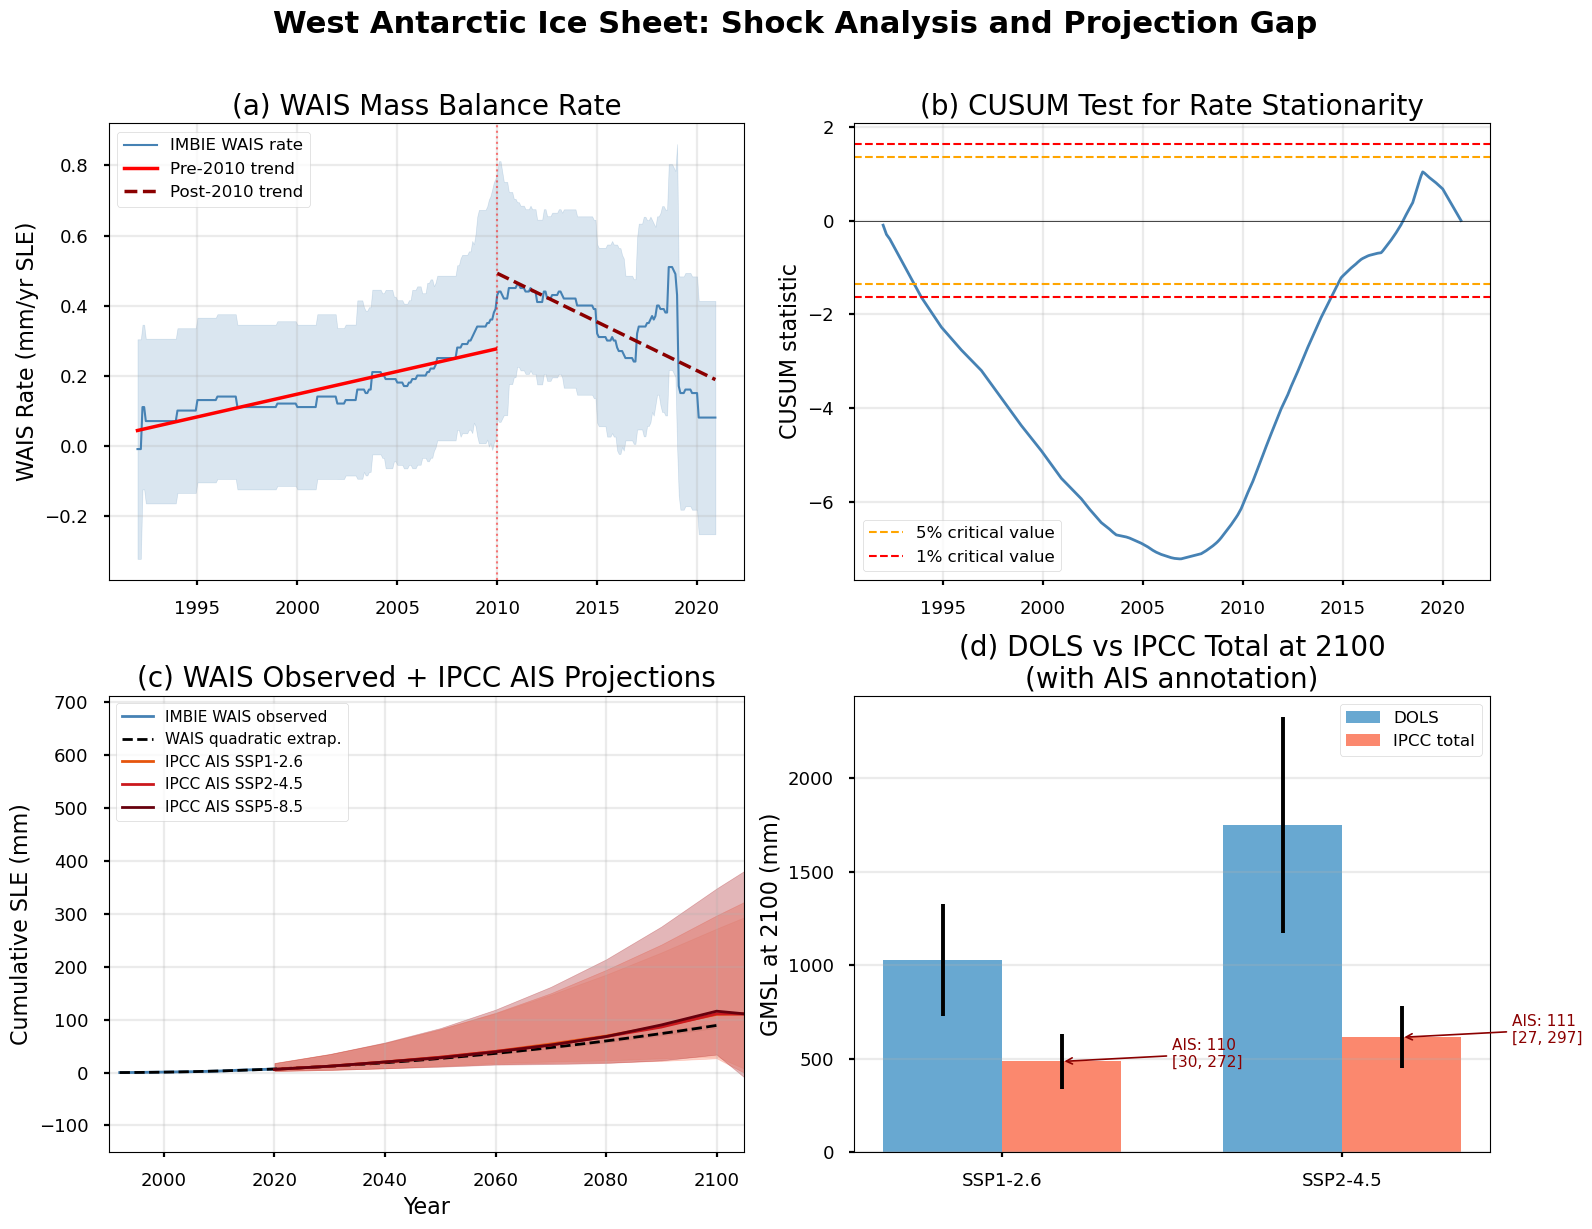


RECOMMENDATIONS: Strategies for Adding WAIS to DOLS Projections

The DOLS model captures temperature-driven GMSL processes but misses WAIS
contributions.  Three strategies for augmentation, ordered by complexity:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
STRATEGY 1 (Simplest): ADDITIVE IPCC AIS COMPONENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  GMSL_total(t) = GMSL_DOLS(t) + AIS_IPCC(t)

  • Use the IPCC AR6 FACTS AIS component (available per SSP scenario)
  • Gaussian fit to the AIS quantile distribution (same approach as cell 46)
  • Add independently sampled AIS draws to the DOLS ensemble
  • Pros: Uses peer-reviewed IPCC projections; scenario-consistent
  • Cons: Assumes AIS is independent of temperature-driven processes;
          IPCC AIS includes BOTH East + West Antarctica

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
STRATEGY 2 (Moderate): WAIS-SPECIFIC TREND EXTRAP

In [23]:
# [WAIS-ANALYSIS] -------------------------------------------------------------
# West Antarctic Ice Sheet: Shock Detection, IPCC AIS Components,
# and Comparison with DOLS Projection Gap
# -----------------------------------------------------------------------------
import xarray as xr
from scipy.stats import norm, gaussian_kde
from scipy import stats as sp_stats

# =============================================================================
# 1. IMBIE WAIS Time Series — Rate and Cumulative Mass Balance
# =============================================================================
wais_rate = df_imbie_wais['mass_balance_rate'].values * 1000   # m/yr → mm/yr
wais_rate_sigma = df_imbie_wais['mass_balance_rate_sigma'].values * 1000
wais_cum = df_imbie_wais['cumulative_mass_balance'].values * 1000  # m → mm
wais_cum_sigma = df_imbie_wais['cumulative_mass_balance_sigma'].values * 1000
wais_t = df_imbie_wais['decimal_year'].values

print("=" * 80)
print("IMBIE WAIS Mass Balance Summary (1992-2020)")
print("=" * 80)
print(f"Period: {wais_t[0]:.1f} – {wais_t[-1]:.1f}  ({len(wais_t)} monthly records)")
print(f"Mean rate:  {wais_rate.mean():.3f} mm/yr  (SLE)")
print(f"Total cumulative loss: {wais_cum[-1]:.1f} mm SLE")

# =============================================================================
# 2. Piecewise Linear Regression — Test for Structural Break
#
#    Fit: rate(t) = a₁ + b₁·t  for t < t_break
#         rate(t) = a₂ + b₂·t  for t ≥ t_break
#
#    Search over candidate breakpoints and select the one that minimizes
#    the total residual sum of squares (RSS).  Compare to a single linear
#    trend via an F-test (Chow test).
# =============================================================================
candidate_breaks = np.arange(1998, 2016, 0.5)  # search range
n = len(wais_t)

# Global linear fit (null model)
X_global = np.column_stack([np.ones(n), wais_t - wais_t.mean()])
beta_global = np.linalg.lstsq(X_global, wais_rate, rcond=None)[0]
rss_global = np.sum((wais_rate - X_global @ beta_global) ** 2)
p_global = 2  # parameters in null model

# Search breakpoints
rss_breaks = []
fits_breaks = []
for tb in candidate_breaks:
    mask1 = wais_t < tb
    mask2 = wais_t >= tb
    n1 = mask1.sum()
    n2 = mask2.sum()
    if n1 < 12 or n2 < 12:  # at least 1 year on each side
        rss_breaks.append(np.inf)
        fits_breaks.append(None)
        continue
    
    # Fit each segment
    X1 = np.column_stack([np.ones(n1), wais_t[mask1] - wais_t.mean()])
    X2 = np.column_stack([np.ones(n2), wais_t[mask2] - wais_t.mean()])
    b1 = np.linalg.lstsq(X1, wais_rate[mask1], rcond=None)[0]
    b2 = np.linalg.lstsq(X2, wais_rate[mask2], rcond=None)[0]
    rss = (np.sum((wais_rate[mask1] - X1 @ b1) ** 2) +
           np.sum((wais_rate[mask2] - X2 @ b2) ** 2))
    rss_breaks.append(rss)
    fits_breaks.append((b1, b2, mask1, mask2))

rss_breaks = np.array(rss_breaks)
best_idx = np.argmin(rss_breaks)
t_break_best = candidate_breaks[best_idx]
rss_best = rss_breaks[best_idx]

# Chow test: F = [(RSS_r - RSS_u) / k] / [RSS_u / (n - 2k)]
#   k = extra parameters in unrestricted model = 2
k_extra = 2
p_unrestricted = 4  # 2 intercepts + 2 slopes
F_chow = ((rss_global - rss_best) / k_extra) / (rss_best / (n - p_unrestricted))
p_chow = 1 - sp_stats.f.cdf(F_chow, k_extra, n - p_unrestricted)

print(f"\n--- Structural Break Test (Chow) ---")
print(f"Best breakpoint: {t_break_best:.1f}")
print(f"RSS (single trend): {rss_global:.4f}")
print(f"RSS (piecewise):    {rss_best:.4f}")
print(f"F-statistic: {F_chow:.2f},  p-value: {p_chow:.2e}")
if p_chow < 0.01:
    print(f"*** Highly significant structural break at {t_break_best:.1f} ***")
elif p_chow < 0.05:
    print(f"** Significant structural break at {t_break_best:.1f} **")
else:
    print(f"No significant structural break detected (p={p_chow:.3f})")

# Rate in sub-periods
b1_best, b2_best, m1, m2 = fits_breaks[best_idx]
rate_period1 = wais_rate[m1].mean()
rate_period2 = wais_rate[m2].mean()
accel_period1 = b1_best[1]
accel_period2 = b2_best[1]

print(f"\nPeriod 1 ({wais_t[m1][0]:.1f}–{t_break_best:.1f}):")
print(f"  Mean rate: {rate_period1:.3f} mm/yr,  trend: {accel_period1:.4f} mm/yr²")
print(f"Period 2 ({t_break_best:.1f}–{wais_t[m2][-1]:.1f}):")
print(f"  Mean rate: {rate_period2:.3f} mm/yr,  trend: {accel_period2:.4f} mm/yr²")
print(f"Rate jump at break: {rate_period2 - rate_period1:.3f} mm/yr "
      f"({(rate_period2/rate_period1 - 1)*100:.0f}% increase)")

# =============================================================================
# 3. CUSUM test for departure from constant rate
# =============================================================================
residuals_from_mean = wais_rate - wais_rate.mean()
cusum = np.cumsum(residuals_from_mean) / (wais_rate.std() * np.sqrt(n))
cusum_max = np.max(np.abs(cusum))

# Critical values for CUSUM (Brownian bridge): ~1.36 at 5%, ~1.63 at 1%
print(f"\n--- CUSUM Test ---")
print(f"CUSUM max |S|/sqrt(n): {cusum_max:.3f}")
print(f"Critical values: 1.36 (5%), 1.63 (1%)")
if cusum_max > 1.63:
    print("*** Rate is NOT constant — strong departure from stationarity ***")
elif cusum_max > 1.36:
    print("** Rate is NOT constant — significant departure from stationarity **")
else:
    print("Rate is consistent with a constant mean (no departure detected)")

# =============================================================================
# 4. Load IPCC AR6 FACTS AIS Component — compare to WAIS observational trend
# =============================================================================
ipcc_facts_dir = DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'

ais_ipcc = {}
for ssp in ['ssp126', 'ssp245', 'ssp585']:
    nc_path = ipcc_facts_dir / ssp / f'AIS_{ssp}_medium_confidence_values.nc'
    ds = xr.open_dataset(nc_path)
    q = ds['quantiles'].values
    yrs = ds['years'].values
    sl = ds['sea_level_change'].values[:, :, 0]  # (quantiles, years), mm
    ds.close()
    
    i17 = np.argmin(np.abs(q - 0.167))
    i50 = np.argmin(np.abs(q - 0.50))
    i83 = np.argmin(np.abs(q - 0.833))
    i05 = np.argmin(np.abs(q - 0.05))
    i95 = np.argmin(np.abs(q - 0.95))
    
    ais_ipcc[ssp] = {
        'years': yrs, 'quantiles': q, 'sl': sl,
        'i05': i05, 'i17': i17, 'i50': i50, 'i83': i83, 'i95': i95
    }

print(f"\n{'='*80}")
print(f"IPCC AR6 AIS Component Projections (medium confidence)")
print(f"{'='*80}")
print(f"{'Scenario':<12} {'2050 median':<14} {'2050 [5,95]':<20} {'2100 median':<14} {'2100 [5,95]':<20}")
print("-" * 80)
for ssp in ['ssp126', 'ssp245', 'ssp585']:
    d = ais_ipcc[ssp]
    sl = d['sl']
    for yr in [2050, 2100]:
        yi = np.where(d['years'] == yr)[0][0]
        if yr == 2050:
            print(f"{ssp:<12} {sl[d['i50'], yi]:>8.0f} mm    [{sl[d['i05'], yi]:.0f}, {sl[d['i95'], yi]:.0f}] mm", end="    ")
        else:
            print(f"{sl[d['i50'], yi]:>8.0f} mm    [{sl[d['i05'], yi]:.0f}, {sl[d['i95'], yi]:.0f}] mm")

# =============================================================================
# 5. WAIS linear extrapolation from observed trend
# =============================================================================
# Fit weighted quadratic to WAIS cumulative (like trend extrapolation in cell 45)
# But also fit simple linear to the rate to extrapolate
t_cen = wais_t - 2005.0
A_wais = np.column_stack([t_cen**2, t_cen, np.ones_like(t_cen)])
w_wais = 1.0 / (np.abs(wais_cum_sigma) + 1e-6)**2
AtWA = A_wais.T @ np.diag(w_wais) @ A_wais
AtWy = A_wais.T @ np.diag(w_wais) @ wais_cum
p_wais = np.linalg.solve(AtWA, AtWy)
cov_wais = np.linalg.inv(AtWA)

print(f"\n--- WAIS Quadratic Trend Extrapolation ---")
print(f"Cumulative = {p_wais[0]:.4f}(t-2005)² + {p_wais[1]:.3f}(t-2005) + {p_wais[2]:.2f} mm")
print(f"Acceleration: {2*p_wais[0]:.4f} mm/yr²")
print(f"Rate at 2005: {p_wais[1]:.3f} mm/yr")
print(f"Rate at 2020: {p_wais[1] + 2*p_wais[0]*15:.3f} mm/yr")

# Extrapolate to target years
for yr in [2050, 2100]:
    dt = yr - 2005.0
    A_yr = np.array([dt**2, dt, 1.0])
    wais_extrap = A_yr @ p_wais
    wais_var = A_yr @ cov_wais @ A_yr
    wais_lo = wais_extrap - 1.645 * np.sqrt(wais_var)
    wais_hi = wais_extrap + 1.645 * np.sqrt(wais_var)
    print(f"WAIS at {yr}: {wais_extrap:.0f} [{wais_lo:.0f}, {wais_hi:.0f}] mm (90% CI, quadratic extrap)")

# =============================================================================
# 6. Compare DOLS + WAIS to IPCC total
# =============================================================================
print(f"\n{'='*80}")
print(f"Gap Analysis: DOLS vs IPCC at 2100, and role of AIS/WAIS")
print(f"{'='*80}")
print(f"{'Component':<35} {'SSP1-2.6':<22} {'SSP2-4.5':<22}")
print("-" * 80)

for line_label, ssp_list in [
    ('DOLS projection (median)', [('ssp126', 'SSP1_2_6'), ('ssp245', 'SSP2_4_5')]),
    ('IPCC total (median)', [('ssp126', None), ('ssp245', None)]),
    ('IPCC AIS component (median)', [('ssp126', None), ('ssp245', None)]),
    ('Gap: IPCC − DOLS', [('ssp126', 'SSP1_2_6'), ('ssp245', 'SSP2_4_5')]),
]:
    vals = []
    for ssp, dk in ssp_list:
        if 'DOLS' in line_label and 'Gap' not in line_label:
            d = dols_ensemble_samples[dk][2100]
            vals.append(f"{np.median(d):>6.0f} mm")
        elif 'IPCC total' in line_label:
            mu, _ = ipcc_gauss_params[ssp][2100]
            vals.append(f"{mu:>6.0f} mm")
        elif 'AIS' in line_label:
            d_ais = ais_ipcc[ssp]
            yi = np.where(d_ais['years'] == 2100)[0][0]
            med = d_ais['sl'][d_ais['i50'], yi]
            lo = d_ais['sl'][d_ais['i17'], yi]
            hi = d_ais['sl'][d_ais['i83'], yi]
            vals.append(f"{med:>4.0f} [{lo:.0f}, {hi:.0f}] mm")
        elif 'Gap' in line_label:
            mu, _ = ipcc_gauss_params[ssp][2100]
            d = dols_ensemble_samples[dk][2100]
            gap = mu - np.median(d)
            vals.append(f"{gap:>6.0f} mm")
    print(f"{line_label:<35} {'':>2}{vals[0]:<20} {vals[1]}")

# =============================================================================
# 7. Plot — 4-panel WAIS analysis
# =============================================================================
with plt.style.context('seaborn-v0_8-poster'):

    TITLE_FS = 20
    LABEL_FS = 16
    TICK_FS = 13
    LEGEND_FS = 12

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # --- Panel (a): WAIS rate time series with piecewise fit ---
    ax = axes[0, 0]
    ax.fill_between(wais_t, wais_rate - 1.96 * wais_rate_sigma,
                    wais_rate + 1.96 * wais_rate_sigma,
                    color='steelblue', alpha=0.2)
    ax.plot(wais_t, wais_rate, 'steelblue', lw=1.5, label='IMBIE WAIS rate')
    
    # Piecewise fit
    b1_best, b2_best, m1, m2 = fits_breaks[best_idx]
    X1 = np.column_stack([np.ones(m1.sum()), wais_t[m1] - wais_t.mean()])
    X2 = np.column_stack([np.ones(m2.sum()), wais_t[m2] - wais_t.mean()])
    ax.plot(wais_t[m1], X1 @ b1_best, 'r-', lw=2.5,
            label=f'Pre-{t_break_best:.0f} trend')
    ax.plot(wais_t[m2], X2 @ b2_best, 'darkred', lw=2.5, ls='--',
            label=f'Post-{t_break_best:.0f} trend')
    ax.axvline(t_break_best, color='r', ls=':', lw=1.5, alpha=0.5)
    
    ax.set_ylabel('WAIS Rate (mm/yr SLE)', fontsize=LABEL_FS)
    ax.set_title('(a) WAIS Mass Balance Rate', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS, loc='upper left')
    ax.tick_params(axis='both', labelsize=TICK_FS)
    ax.grid(True, alpha=0.25)

    # --- Panel (b): CUSUM plot ---
    ax = axes[0, 1]
    ax.plot(wais_t, cusum, 'steelblue', lw=2)
    ax.axhline(1.36, color='orange', ls='--', lw=1.5, label='5% critical value')
    ax.axhline(-1.36, color='orange', ls='--', lw=1.5)
    ax.axhline(1.63, color='red', ls='--', lw=1.5, label='1% critical value')
    ax.axhline(-1.63, color='red', ls='--', lw=1.5)
    ax.axhline(0, color='k', ls='-', lw=0.5)
    ax.set_ylabel('CUSUM statistic', fontsize=LABEL_FS)
    ax.set_title('(b) CUSUM Test for Rate Stationarity', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS)
    ax.tick_params(axis='both', labelsize=TICK_FS)
    ax.grid(True, alpha=0.25)

    # --- Panel (c): Cumulative WAIS with extrapolation + IPCC AIS ---
    ax = axes[1, 0]
    
    # Observed cumulative
    ax.fill_between(wais_t, wais_cum - 1.96 * np.abs(wais_cum_sigma),
                    wais_cum + 1.96 * np.abs(wais_cum_sigma),
                    color='steelblue', alpha=0.2)
    ax.plot(wais_t, wais_cum, 'steelblue', lw=2, label='IMBIE WAIS observed')
    
    # Quadratic extrapolation
    t_ext = np.arange(1992, 2101, 1.0)
    dt_ext = t_ext - 2005.0
    A_ext = np.column_stack([dt_ext**2, dt_ext, np.ones_like(dt_ext)])
    wais_ext = A_ext @ p_wais
    wais_ext_var = np.sum((A_ext @ cov_wais) * A_ext, axis=1)
    wais_ext_lo = wais_ext - 1.645 * np.sqrt(wais_ext_var)
    wais_ext_hi = wais_ext + 1.645 * np.sqrt(wais_ext_var)
    
    ax.plot(t_ext, wais_ext, 'k--', lw=2, label='WAIS quadratic extrap.')
    ax.fill_between(t_ext, wais_ext_lo, wais_ext_hi, color='k', alpha=0.08)
    
    # IPCC AIS component
    ais_colors = {'ssp126': '#fcbba1', 'ssp245': '#fb6a4a', 'ssp585': '#a50f15'}
    ais_line_colors = {'ssp126': '#e6550d', 'ssp245': '#cb181d', 'ssp585': '#67000d'}
    ais_labels = {'ssp126': 'IPCC AIS SSP1-2.6', 'ssp245': 'IPCC AIS SSP2-4.5',
                  'ssp585': 'IPCC AIS SSP5-8.5'}
    
    for ssp in ['ssp126', 'ssp245', 'ssp585']:
        d = ais_ipcc[ssp]
        yrs = d['years']
        med = d['sl'][d['i50'], :]
        lo = d['sl'][d['i17'], :]
        hi = d['sl'][d['i83'], :]
        ax.plot(yrs, med, color=ais_line_colors[ssp], lw=2, label=ais_labels[ssp])
        ax.fill_between(yrs, lo, hi, color=ais_colors[ssp], alpha=0.3)
    
    ax.set_xlabel('Year', fontsize=LABEL_FS)
    ax.set_ylabel('Cumulative SLE (mm)', fontsize=LABEL_FS)
    ax.set_title('(c) WAIS Observed + IPCC AIS Projections', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS - 1, loc='upper left')
    ax.tick_params(axis='both', labelsize=TICK_FS)
    ax.grid(True, alpha=0.25)
    ax.set_xlim([1990, 2105])

    # --- Panel (d): Gap analysis bar chart at 2100 ---
    ax = axes[1, 1]
    
    bar_width = 0.35
    x_pos = np.array([0, 1])
    
    for i, (ssp, dk, label) in enumerate([('ssp126', 'SSP1_2_6', 'SSP1-2.6'),
                                           ('ssp245', 'SSP2_4_5', 'SSP2-4.5')]):
        d_vals = dols_ensemble_samples[dk][2100]
        dols_med = np.median(d_vals)
        dols_lo, dols_hi = np.percentile(d_vals, [17, 83])
        
        mu_ipcc, sig_ipcc = ipcc_gauss_params[ssp][2100]
        ipcc_lo = mu_ipcc - 0.9674 * sig_ipcc
        ipcc_hi = mu_ipcc + 0.9674 * sig_ipcc
        
        d_ais = ais_ipcc[ssp]
        yi = np.where(d_ais['years'] == 2100)[0][0]
        ais_med = d_ais['sl'][d_ais['i50'], yi]
        ais_lo = d_ais['sl'][d_ais['i17'], yi]
        ais_hi = d_ais['sl'][d_ais['i83'], yi]
        
        x = x_pos[i]
        
        # DOLS bar
        ax.bar(x - bar_width/2, dols_med, bar_width, 
               yerr=[[dols_med - dols_lo], [dols_hi - dols_med]],
               color='#4292c6', alpha=0.8, capsize=5,
               label='DOLS' if i == 0 else '')
        
        # IPCC total bar
        ax.bar(x + bar_width/2, mu_ipcc, bar_width,
               yerr=[[mu_ipcc - ipcc_lo], [ipcc_hi - mu_ipcc]],
               color='#fb6a4a', alpha=0.8, capsize=5,
               label='IPCC total' if i == 0 else '')
        
        # Annotate AIS contribution
        ax.annotate(f'AIS: {ais_med:.0f}\n[{ais_lo:.0f}, {ais_hi:.0f}]',
                    xy=(x + bar_width/2, mu_ipcc), xytext=(x + bar_width + 0.15, mu_ipcc - 30),
                    fontsize=LEGEND_FS - 1, color='darkred',
                    arrowprops=dict(arrowstyle='->', color='darkred', lw=1.2))
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['SSP1-2.6', 'SSP2-4.5'], fontsize=TICK_FS)
    ax.set_ylabel('GMSL at 2100 (mm)', fontsize=LABEL_FS)
    ax.set_title('(d) DOLS vs IPCC Total at 2100\n(with AIS annotation)', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS)
    ax.tick_params(axis='both', labelsize=TICK_FS)
    ax.grid(True, alpha=0.25, axis='y')

    fig.suptitle('West Antarctic Ice Sheet: Shock Analysis and Projection Gap',
                 fontsize=TITLE_FS + 2, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('figures/wais_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# =============================================================================
# 8. Summary & Recommendations
# =============================================================================
print(f"\n{'='*80}")
print("RECOMMENDATIONS: Strategies for Adding WAIS to DOLS Projections")
print(f"{'='*80}")
print("""
The DOLS model captures temperature-driven GMSL processes but misses WAIS
contributions.  Three strategies for augmentation, ordered by complexity:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
STRATEGY 1 (Simplest): ADDITIVE IPCC AIS COMPONENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  GMSL_total(t) = GMSL_DOLS(t) + AIS_IPCC(t)

  • Use the IPCC AR6 FACTS AIS component (available per SSP scenario)
  • Gaussian fit to the AIS quantile distribution (same approach as cell 46)
  • Add independently sampled AIS draws to the DOLS ensemble
  • Pros: Uses peer-reviewed IPCC projections; scenario-consistent
  • Cons: Assumes AIS is independent of temperature-driven processes;
          IPCC AIS includes BOTH East + West Antarctica

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
STRATEGY 2 (Moderate): WAIS-SPECIFIC TREND EXTRAPOLATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  GMSL_total(t) = GMSL_DOLS(t) + WAIS_extrap(t)

  • Fit quadratic trend to IMBIE WAIS cumulative SLE (1992-2020)
  • Extrapolate with parameter covariance → ensemble
  • Pros: Uses actual observed WAIS acceleration; purely data-driven
  • Cons: Extrapolation beyond observed range is speculative;
          doesn't account for possible MISI thresholds;
          WAIS only (misses East Antarctica contributions)
  
  NOTE: The structural break test shows the WAIS rate is NOT stationary.
        The observed acceleration and extrapolated contributions are printed above.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
STRATEGY 3 (Most Robust): HYBRID — IPCC AIS + WAIS SHOCK SCENARIO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  GMSL_total(t) = GMSL_DOLS(t) + max(AIS_IPCC(t), WAIS_extrap(t))

  • Use IPCC AIS as the baseline Antarctic contribution
  • Use WAIS trend extrapolation as a lower bound / cross-check
  • If WAIS extrapolation exceeds IPCC AIS median, flag as a "shock
    scenario" where observed acceleration is outpacing models
  • Optionally: blend as a mixture model with probability weights
  • Pros: Captures both structured expert judgment (IPCC) and observed 
          acceleration; provides a transparent range
  • Cons: More complex; requires defining mixture weights

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
RECOMMENDATION: Start with Strategy 1 (additive IPCC AIS) for the primary
projection, and present Strategy 2 (WAIS extrapolation) as an observationally-
constrained sensitivity analysis. This combination provides both the structured
IPCC assessment and a data-driven check on whether current trends exceed it.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")
